# Instanciação de Parâmetros

In [452]:
import pyomo as pyo

# Número de meses
T=60

# Parâmetros
a = 60  # Constante da demanda
b = 1/2000    # Elasticidade da demanda
variable_cost_percentage = 0.35  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
variable_expenses_percentage = 0.03  # Percentual de custos variáveis
taxes_percentage = 0.07  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
CF = 112_500    # Custo fixo mensal (salários, aluguel, etc)
DF = 247_500    # Despesa fixa mensal
theta_AR = 35/30 # 35 dias de recebimento
theta_I = 30/30 # 30 dias de estoque
theta_AP = 30/30 # 30 dias de pagamento

# Intervalos de preço e quantidade
P_min = 3 # 3 reais por lata
P_max = 3
Q_min = 250_000 # 250.000 latas
inital_sales = 250_000 # Vendas iniciais
Q_max = 1_000_000

# Variação inicial da NCG (exemplo)
initial_NCG = 875_000 + 262_500 - 262_500 #CR + Estoque Inicial - CP
initial_inventory = 262_500 # 

# Meses usados no cálculo do FCO futuro
months_future_FCO = 12

# Taxa de Incremento do Lucro
profit_increment_rate = 0.8 #0.7
growth_rate = 1.019446 # 1.26 a.a

# Value at risk
alpha_var = 0.05
epsilon_var = 10000  # Valor inicial, será atualizado no loop

# Taxa de Desconto
GAMMA = 0.01

# Modelo Determinístico

In [453]:
from pyomo.environ import *

# Cria um modelo concreto
naive_model = model = ConcreteModel()

# Períodos
T=60

# Variáveis de decisão
model.P = Param(initialize=P_min)
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos

initialize_variable_costs=[variable_cost_percentage*1.015**t for t in range(0, T)]

model.variable_cost_percentage = Param(range(1, T+1), initialize=lambda model, t: initialize_variable_costs[t-1], mutable=True)
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=Q_min)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, t):
    # return 0
    return revenue_rule(model, t) * model.theta_AR

def I_rule(model, t):
    # return 0
    return (model.variable_cost_percentage[t] * revenue_rule(model, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, t):
    i_t_minus_1 = I_rule(model, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, t) + model.variable_cost_percentage[t] * revenue_rule(model, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    else:
        # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) 
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(revenue_rule(model, t_period) -\
        model.variable_cost_percentage[t_period] * revenue_rule(model, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, t_period) - \
        model.taxes_percentage * revenue_rule(model, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, t):
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t)) >= 0

# model.fco = Constraint(range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, t) <= 10e10
    
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, t-1) -\
        model.variable_cost_percentage[t-1] * revenue_rule(model, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, t-1) - \
        model.taxes_percentage * revenue_rule(model, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, T+1), rule=profit_rule)

def non_regression_rule(model, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, T+1), rule=non_regression_rule)

# Componentes da NCG
model.AR = Expression(range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
for t in range(1, T+1):
    print(f'Mês {t}: Preço = {model.P.value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpk11sdt1g.pyomo.lp
Reading time = 0.01 seconds
x1: 120 rows, 60 columns, 234 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120 rows, 60 columns and 234 nonzeros
Model fingerprint: 0x0d657acc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 4e+06]
  Bounds range     [1e+00, 1e+06]
  RHS range        [2e+05, 3e+05]
Presolve removed 6 rows and 2 columns
Presolve time: 0.01s
Presolved: 114 rows, 58 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2565286e+05   1.050756e+05   0.000000e+00      0s
      59   -1.5935550e+06   0.000000e+00   0.000000e+00      0s

Solved in 59 iterations and

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [454]:
from pyomo.environ import value


def fco_period(model, t):
    return value(model.P * model.Q[t] - model.variable_cost_percentage[t] * model.P * model.Q[t] - model.variable_expenses_percentage * model.P * model.Q[t] - model.taxes_percentage * model.P * model.Q[t] - model.fix_costs - model.fix_expenses - model.NCG[t])

def revenue_period(model, t):
    return value(model.P * model.Q[t])

def profit_period(model, t):
    return value(model.P * model.Q[t] - model.variable_cost_percentage[t] * model.P * model.Q[t] - model.variable_expenses_percentage * model.P * model.Q[t] - model.taxes_percentage * model.P * model.Q[t] - model.fix_costs - model.fix_expenses)

In [455]:
# Verificar se o modelo foi solucionado com sucesso
if result.solver.termination_condition == TerminationCondition.optimal:
    for t in range(1, T+1):
        # Calcula e exibe as componentes diretamente sem usar as expressões model.AR, model.I, model.AP, model.NCG
        AR_value = AR_rule(model, t)()
        I_value = I_rule(model, t)()
        AP_value = AP_rule(model, t)()
        NCG_value = NCG_rule(model, t)()
        revenue_value = revenue_rule(model, t)()

        print(f'Mês {t}: Preço = {model.P.value}, Quantidade = {model.Q[t].value}')
        print(f'  AR = {AR_value}, Estoque (I) = {I_value}, AP = {AP_value}, NCG = {NCG_value}')
        print(f'  NCG = AR - I - AP = {AR_value} - {I_value} - {AP_value} = {NCG_value}')
        # agora o lucro
        # print(f'  Lucro = {revenue_value - model.variable_cost_percentage * revenue_value - model.variable_expenses_percentage * revenue_value - model.taxes_percentage * revenue_value - model.fix_costs - model.fix_expenses}')
else:
    print("O modelo não encontrou uma solução ótima.")

Mês 1: Preço = 3, Quantidade = 250000
  AR = 875000.0, Estoque (I) = 262499.99999999994, AP = 262499.9999999999, NCG = 1.1641532182693481e-10
  NCG = AR - I - AP = 875000.0 - 262499.99999999994 - 262499.9999999999 = 1.1641532182693481e-10
Mês 2: Preço = 3, Quantidade = 254861.50000000003
  AR = 892015.2500000001, Estoque (I) = 271618.643625, AP = 280737.2872500001, NCG = 7896.606374999799
  NCG = AR - I - AP = 892015.2500000001 - 271618.643625 - 280737.2872500001 = 7896.606374999799
Mês 3: Preço = 3, Quantidade = 259817.53672900004
  AR = 909361.3785515002, Estoque (I) = 281054.0478654657, AP = 290489.45210593136, NCG = 17029.36793603457
  NCG = AR - I - AP = 909361.3785515002 - 281054.0478654657 - 290489.45210593136 = 17029.36793603457
Mês 4: Preço = 3, Quantidade = 264869.9485482322
  AR = 927044.8199188127, Estoque (I) = 290817.2162534614, AP = 300580.38464145706, NCG = 17355.677219782432
  NCG = AR - I - AP = 927044.8199188127 - 290817.2162534614 - 300580.38464145706 = 17355.677219

## Gráficos de Comportamento da Solução

### Quantidade de Vendas por Período

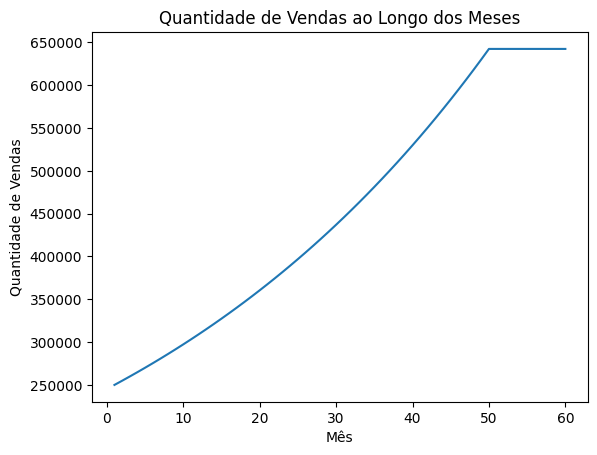

In [456]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

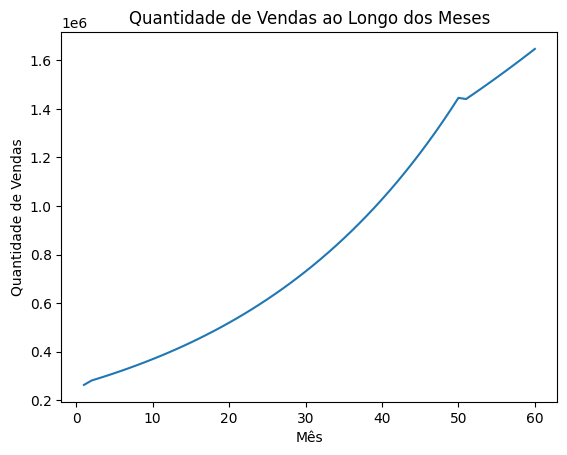

In [457]:
import matplotlib.pyplot as plt

# plt.plot(range(1, 3), [value(AR_rule(model, t)) for t in range(1, 3)], label='AR')

plt.plot(range(1, T+1), [value(AP_rule(model, t)) for t in range(1, T+1)], label='AP')

# plt.plot(range(1, 3), [value(I_rule(model, t)) for t in range(1, 3)], label='I')

plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

# plt.plot(range(1, 3), [value(AP_rule(model, t)) for t in range(1, 3)])
# plt.xlabel('Mês')
# plt.ylabel('Quantidade de Vendas')
# plt.title('Quantidade de Vendas ao Longo dos Meses')
# plt.show()

### Receita por Período

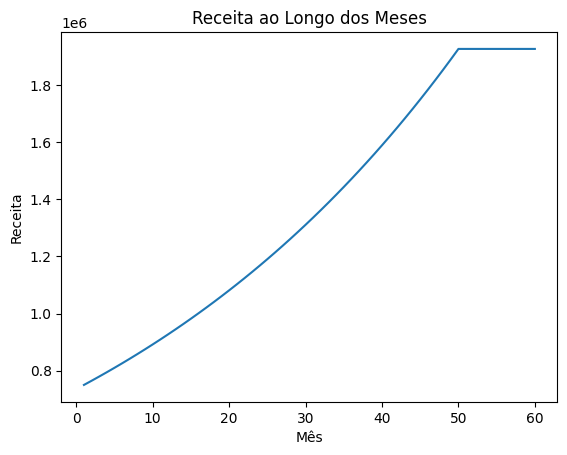

In [458]:
plt.plot(range(1, T+1), [revenue_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses')
plt.show()

### Lucro por Período

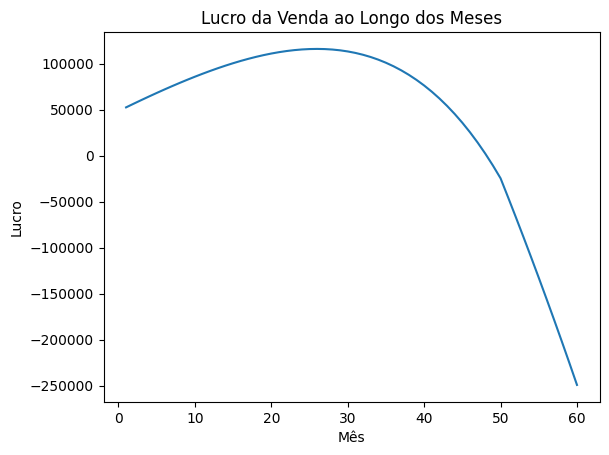

In [459]:
plt.plot(range(1, T+1), [profit_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro da Venda ao Longo dos Meses')
plt.show()

### Fluxo de Caixa Operacional por Período

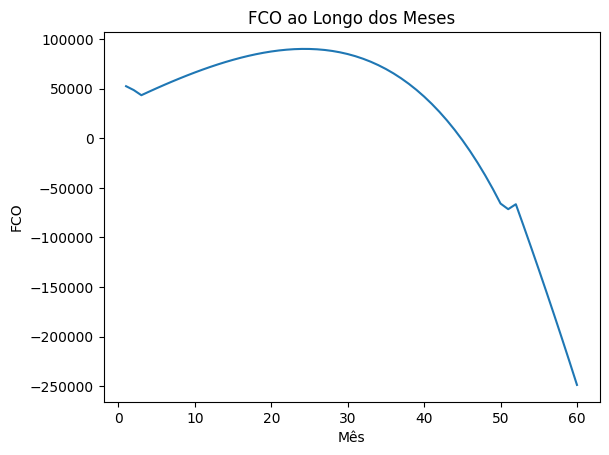

In [460]:
plt.plot(range(1, T+1), [fco_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('FCO')
plt.title('FCO ao Longo dos Meses')
plt.show()

# Descobrindo possíveis variações no valor de custos variáveis com base na variação do dólar

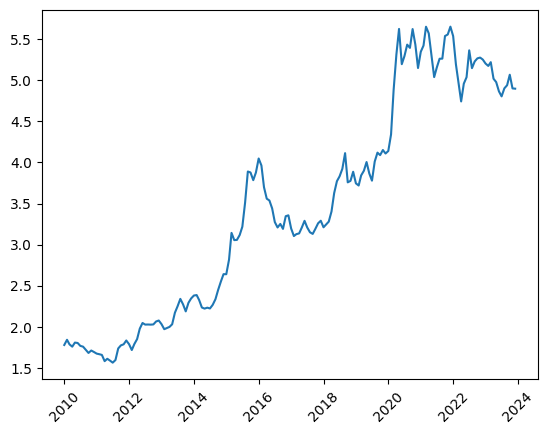

In [461]:
from currency_converter import CurrencyConverter
from datetime import datetime
from numpy import mean
import calendar
import matplotlib.pyplot as plt

c = CurrencyConverter(fallback_on_missing_rate=True)

# Pega a média do dólar mensal desde 2010
dolar_mean = []
for i in range(2010, 2024):
    for j in range(1, 13):
        _, num_days = calendar.monthrange(i, j)
        dolar_mean.append(mean([c.convert(1, 'USD', 'BRL', date=datetime(i, j, k)) for k in range(1, num_days+1)]))

# Plota o gráfico utilizando datas no eixo x
plt.plot([datetime(i, j, 1) for i in range(2010, 2024) for j in range(1, 13)], dolar_mean)
plt.xticks(rotation=45)
plt.show()


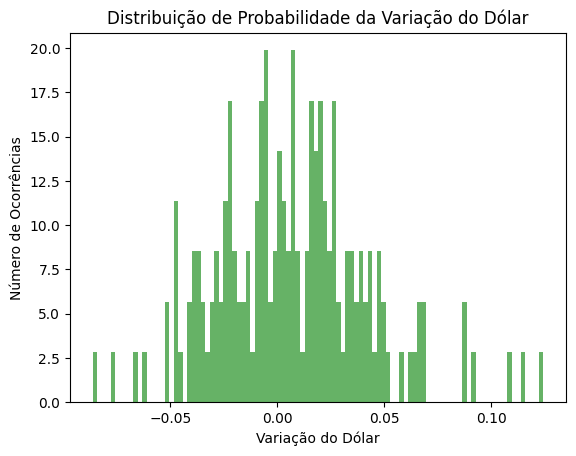

In [462]:
# Distribuição de probabilidades da variação do dólar baseado na série temporal dolar_mean
from scipy.stats import norm
import numpy as np

dolar_mean_variation = np.diff(dolar_mean)

#  Agora uma lista que pega o calor do dolar e soma com a variação
dolar_mean_variation = [(dolar_mean[i] + dolar_mean_variation[i])/dolar_mean[i] - 1 for i in range(len(dolar_mean_variation))]

# plot the histogram
plt.hist(dolar_mean_variation, bins=100, density=True, alpha=0.6, color='g')
plt.xlabel('Variação do Dólar')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição de Probabilidade da Variação do Dólar')
plt.show()


In [463]:
# Extrair os parâmetros dos dados
target_mean = np.mean(dolar_mean_variation)
target_variance = np.var(dolar_mean_variation)
target_skewness = np.mean((dolar_mean_variation - target_mean)**3) / target_variance**(3/2)
target_kurtosis = np.mean((dolar_mean_variation - target_mean)**4) / target_variance**2


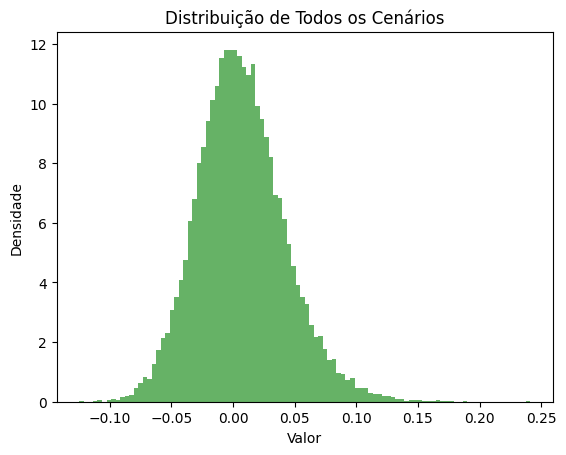

In [464]:
# Baseado no https://bjerring.github.io/equity/2019/12/12/Scenario-Generation-and-Moment-Matching.html

import numpy as np
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def moment_matching_func(x, *args):
    """Função de ajuste de momentos que minimiza o erro entre os cenários gerados e os momentos-alvo."""
    para_match = args[0]
    exp_mu, exp_sds, exp_skew, exp_kur, exp_cov_m = para_match

    # Calcula a matriz de correlação a partir da covariância
    std_ = np.sqrt(np.diag(exp_cov_m)) if exp_cov_m.ndim > 1 else np.sqrt(exp_cov_m)
    exp_cor_m = exp_cov_m / np.outer(std_, std_) if exp_cov_m.ndim > 1 else 1.0

    # Reshape dos cenários gerados
    xx = np.reshape(x, (-1, len(exp_mu)))

    # Calcula os momentos dos cenários
    m1 = np.mean(xx, axis=0)
    m2 = np.std(xx, axis=0)
    m3 = [skew(xx[:, i]) for i in range(len(exp_mu))]
    m4 = [kurtosis(xx[:, i]) for i in range(len(exp_mu))]

    # Calcula o erro como a soma dos quadrados das diferenças
    epsilon = (np.sum((m1 - exp_mu)**2) +
               np.sum((m2 - exp_sds)**2) +
               np.sum((m3 - exp_skew)**2) +
               np.sum((m4 - exp_kur)**2) +
               np.sum((np.corrcoef(xx, rowvar=False) - exp_cor_m)**2))

    return epsilon

def generate_scenarios_with_moment_matching(mu, sigma, skewness, kurtosis, covariance, size=10000):
    """
    Gera cenários ajustando os momentos estatísticos fornecidos.
    """
    # Define os momentos-alvo
    para_match = (mu, sigma, skewness, kurtosis, covariance)

    # Verifica se a covariância é escalar (para uma variável)
    if covariance.ndim == 1:
        covariance = np.array([[covariance[0]]])  # Torna a matriz 2D para compatibilidade

    # Inicializa os cenários com uma distribuição normal multivariada
    x_ini = np.random.multivariate_normal(mu, covariance, size).ravel()

    # Minimiza o erro entre os momentos gerados e os momentos-alvo
    res = minimize(moment_matching_func, x_ini, method='CG', args=(para_match,))

    # Retorna os cenários ajustados
    scenarios = np.reshape(res.x, (-1, len(mu)))

    return scenarios

def extract_moments_and_covariance(data):
    """
    Extrai os momentos estatísticos e a matriz de covariância dos dados fornecidos.
    """
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    skewness = skew(data, axis=0)
    kurtosis_vals = kurtosis(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    
    # Se for uma variável, ajuste a covariância para ser um array
    if covariance.ndim == 0:
        covariance = np.array([[covariance]])
    
    return mu, sigma, skewness, kurtosis_vals, covariance

# Parâmetros dos cenários
scenarios = 500  # Número de cenários
initial_variable_costs = 0.35
dolar_affect_parameter = 0.5

# Substitua pelo histórico da variação do dólar
historical_data = np.array(dolar_mean_variation).reshape(-1, 1)
mu, sigma, skewness, kurtosis_vals, covariance = extract_moments_and_covariance(historical_data)

# Gera os cenários
scenarios_data = []

    # Gerando valor ajustado aos momentos
data_point = generate_scenarios_with_moment_matching(
    mu=mu, 
    sigma=sigma, 
    skewness=skewness, 
    kurtosis=kurtosis_vals, 
    covariance=covariance, 
    size=(T-1)*scenarios # Subtraio 1 pois o primeiro mês é o valor percentual inicial
)
    
scenarios_data = data_point

all_data = scenarios_data.copy()

# Visualiza os dados de todos os cenários
plt.hist(all_data, bins=100, density=True, alpha=0.6, color='g')
plt.title('Distribuição de Todos os Cenários')
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.show()

In [465]:
# Mostrar Percentual de Variação do Dólar para cada cenári

In [466]:
# scenarios_alt = np.zeros((scenarios, T))

scenarios_data = all_data.reshape(scenarios, (T-1)).tolist()

values = []
for i in range(scenarios):
    values_list = [initial_variable_costs]
    for t in range(1, T):
        values_list.append(values_list[t-1] + scenarios_data[i][t-1] * dolar_affect_parameter)
    values.append(values_list)

scenarios_data = values

In [467]:
import statsmodels.sandbox.distributions.extras as extras
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt  
import numpy as np

def generate_normal_four_moments(mu, sigma, skew, kurt, size=10000, sd_wide=10):
   f = extras.pdf_mvsk([mu, sigma, skew, kurt])
   x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=500)
   y = [f(i) for i in x]
   yy = np.cumsum(y) / np.sum(y)
   inv_cdf = interpolate.interp1d(yy, x, fill_value="extrapolate")
   rr = np.random.rand(size)

   return inv_cdf(rr)

2 de 6000
3 de 6000
4 de 6000
5 de 6000
6 de 6000
7 de 6000
8 de 6000
9 de 6000
10 de 6000
11 de 6000
12 de 6000
13 de 6000
14 de 6000
15 de 6000
16 de 6000
17 de 6000
18 de 6000
19 de 6000
20 de 6000
21 de 6000
22 de 6000
23 de 6000
24 de 6000
25 de 6000
26 de 6000
27 de 6000
28 de 6000
29 de 6000
30 de 6000
31 de 6000
32 de 6000
33 de 6000
34 de 6000
35 de 6000
36 de 6000
37 de 6000
38 de 6000
39 de 6000
40 de 6000
41 de 6000
42 de 6000
43 de 6000
44 de 6000
45 de 6000
46 de 6000
47 de 6000
48 de 6000
49 de 6000
50 de 6000
51 de 6000
52 de 6000
53 de 6000
54 de 6000
55 de 6000
56 de 6000
57 de 6000
58 de 6000
59 de 6000
60 de 6000
62 de 6000
63 de 6000
64 de 6000
65 de 6000
66 de 6000
67 de 6000
68 de 6000
69 de 6000
70 de 6000
71 de 6000
72 de 6000
73 de 6000
74 de 6000
75 de 6000
76 de 6000
77 de 6000
78 de 6000
79 de 6000
80 de 6000
81 de 6000
82 de 6000
83 de 6000
84 de 6000
85 de 6000
86 de 6000
87 de 6000
88 de 6000
89 de 6000
90 de 6000
91 de 6000
92 de 6000
93 de 6000
94 de 6

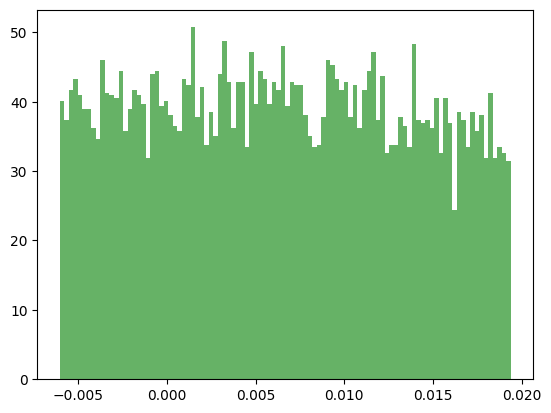

In [468]:
data = generate_normal_four_moments(mu=target_mean, sigma=target_variance, skew=target_skewness, kurt=target_kurtosis)

# plot the histogram
plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

# Criando para 5 cenários
scenarios_alt = 100
scenarios_data_old = []

initial_variable_costs = 0.25
dolar_affect_parameter = 1
for i in range(scenarios_alt):
    scenario_data = []
    for j in range(1, T+1):
        if j == 1:
            scenario_data.append(initial_variable_costs)
            continue

        data = generate_normal_four_moments(mu=target_mean, sigma=target_variance, skew=target_skewness, kurt=target_kurtosis, size=1)[0]
        data = scenario_data[-1] + data * dolar_affect_parameter
        scenario_data.append(data)
        print(f'{i*T+j} de {scenarios_alt*T}')
    
    scenarios_data_old.append(scenario_data)

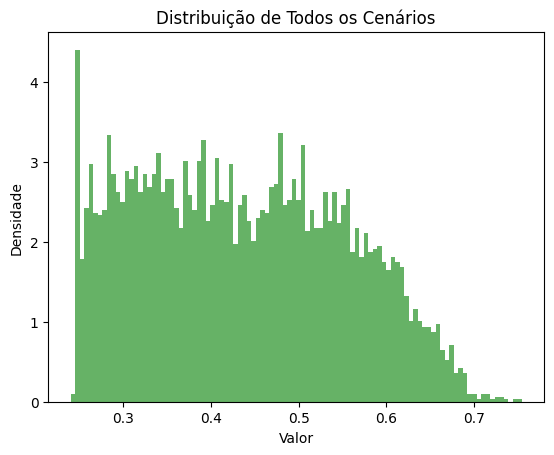

In [469]:
# Visualiza os dados de todos os cenários scenarios_data é uma lista de lista, desconstruímos para um array
all_data_old = np.array(scenarios_data_old).ravel()

plt.hist(all_data_old, bins=100, density=True, alpha=0.6, color='g')
plt.title('Distribuição de Todos os Cenários')
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.show()

# Modelo Múltiplo

In [470]:
from pyomo.environ import *

# Cria um modelo concreto
model = ConcreteModel()

# Períodos
T=60

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=P_min)
model.Q = Var(range(1, scenarios+1), range(1, T+1), bounds=(Q_min, Q_max*2), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1])

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
for i in range(1, scenarios+1):
    model.Q[i, 1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[i, t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG


# Função objetivo

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
# BREAKPOINT
def growth_rule(model, i, t):
    return model.Q[i, t] <= model.Q[i, t-1] * growth_rate if t > 1 else model.Q[i, t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def non_regression_rule(model, i, t):
    return model.Q[i, t] >= model.Q[i, t-1] if t > 1 else model.Q[i, t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmp4zom70cm.pyomo.lp
Reading time = 0.15 seconds
x1: 60000 rows, 29501 columns, 117000 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60000 rows, 29501 columns and 117000 nonzeros
Model fingerprint: 0xd00c6cbb
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 4e+06]
  Bounds range     [1e+00, 2e+06]
  RHS range        [2e+05, 3e+05]
Presolve removed 3000 rows and 501 columns
Presolve time: 0.08s
Presolved: 57000 rows, 29000 columns, 114000 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 1.405e+05
 Factor NZ  : 6.775e+05 (roug

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [471]:
from pyomo.environ import value


def fco_period_multiple(model, i, t):
    return value(model.P * model.Q[i, t] - model.variable_cost_percentage[i, t] * model.P * model.Q[i, t] - model.variable_expenses_percentage * model.P * model.Q[i, t] - model.taxes_percentage * model.P * model.Q[i, t] - model.fix_costs - model.fix_expenses - model.NCG[i, t])

def revenue_period_multiple(model, i, t):
    return value(model.P * model.Q[i, t])

def profit_period_multiple(model, i, t):
    return value(model.P * model.Q[i, t] - model.variable_cost_percentage[i, t] * model.P * model.Q[i, t] - model.variable_expenses_percentage * model.P * model.Q[i, t] - model.taxes_percentage * model.P * model.Q[i, t] - model.fix_costs - model.fix_expenses)

## Gráficos de Comportamento da Solução

### Quantidade de Vendas por Período

Text(0.5, 1.0, 'Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

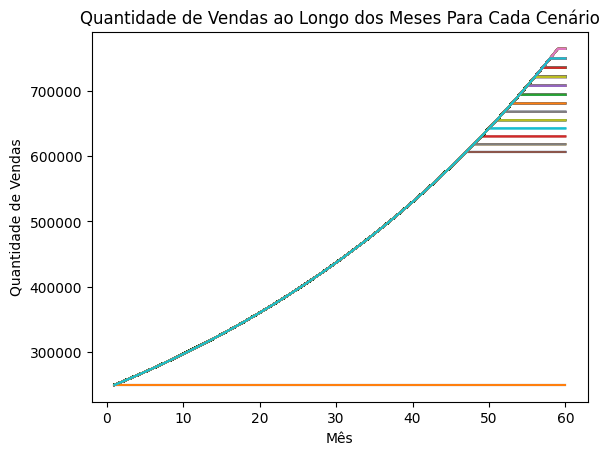

In [472]:
# plot de preço e quantidade para cada cenário
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [model.Q[i, t].value for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

### Receita por Período

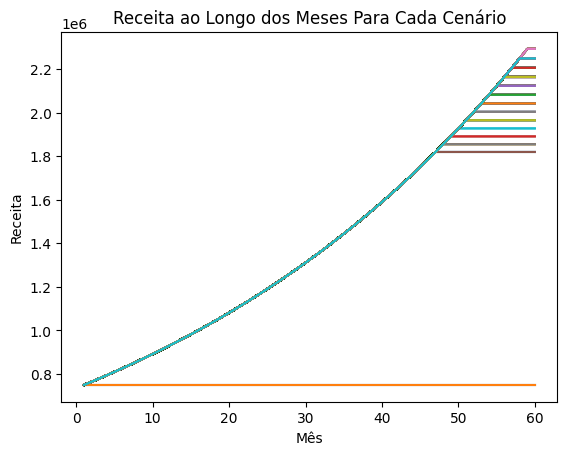

In [473]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

### Lucro por Período

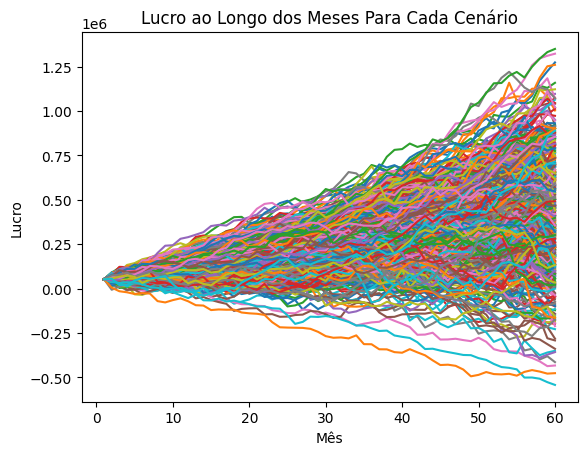

In [474]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

### Fluxo de Caixa Operacional por Período

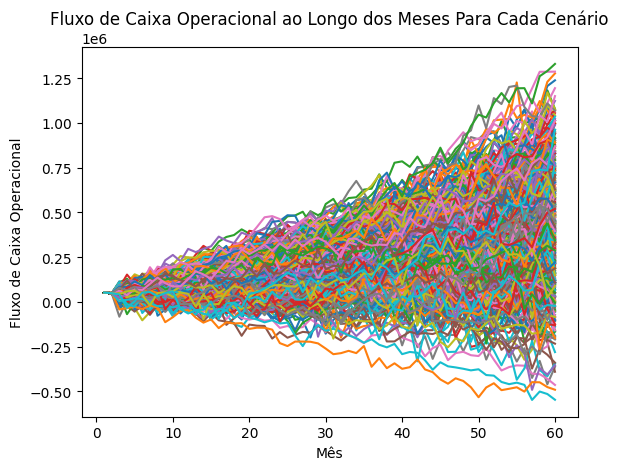

In [475]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

# Modelo Estocástico Mono-objetivo | FCO Último Ano

In [476]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T=60

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=P_min)
model.Q = Var(range(1, T+1), bounds=(Q_min, 2*Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

def other_objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def fco_rule_exp(model, i):
    t_final = T
    return -sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

def non_regression_rule(model, i, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpmydip1zt.pyomo.lp
Reading time = 0.21 seconds
x1: 60000 rows, 60 columns, 117000 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60000 rows, 60 columns and 117000 nonzeros
Model fingerprint: 0x3af3175e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 4e+06]
  Bounds range     [1e+00, 2e+06]
  RHS range        [2e+05, 3e+05]
Presolve removed 59886 rows and 2 columns
Presolve time: 0.05s
Presolved: 114 rows, 58 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4833235e+07   5.257302e+05   0.000000e+00      0s
      62    4.4687060e+06   0.000000e+00   0.000000e+00      0s

Solved in 62 

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [477]:
from pyomo.environ import value


def fco_period(model, i, t):
    return value(3 * model.Q[t] - model.variable_cost_percentage[i, t] * 3 * model.Q[t] - model.variable_expenses_percentage * 3 * model.Q[t] - model.taxes_percentage * 3 * model.Q[t] - model.fix_costs - model.fix_expenses - model.NCG[i, t])

def revenue_period(model, i, t):
    return value(3 * model.Q[t])

def profit_period(model, i, t):
    return value(3 * model.Q[t] - model.variable_cost_percentage[i, t] * 3 * model.Q[t] - model.variable_expenses_percentage * 3 * model.Q[t] - model.taxes_percentage * 3 * model.Q[t] - model.fix_costs - model.fix_expenses)

## Quantidade de Vendas por Período

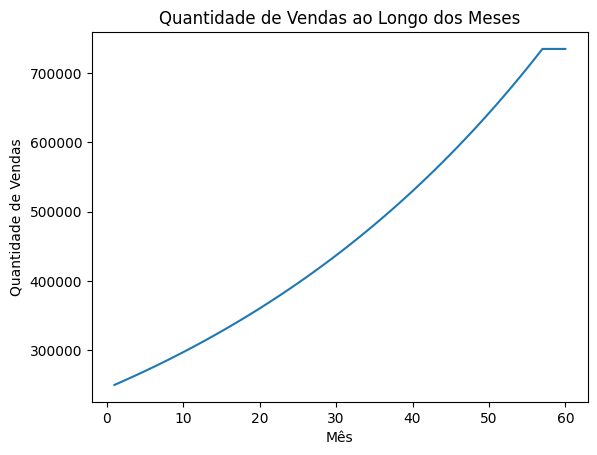

[250000, 254861.50000000003, 259817.53672900004, 264869.9485482322, 270020.6095677012, 275271.4303413547, 280624.35857577267, 286081.3798526372, 291644.5183652516, 297315.8376693823, 303097.44144870114, 308991.4742951126, 315000.1225042554, 321125.61488647317, 327370.22359355557, 333736.2649615559, 340226.1003699983, 346842.1371177933, 353586.82931618596, 360462.67879906856, 367472.23605099524, 374618.1011532429, 381902.9247482689, 389329.4090229238, 396900.3087107836, 404618.43211397354, 412486.6421448619, 420507.85738801095, 428685.05318277824, 437021.2627269706, 445519.5782019593, 454183.15191967465, 463015.19749190466, 472018.9910223323, 481197.8723217526, 490555.2461469214, 500094.5834634945, 509819.42273352563, 519733.3712280018, 529840.1063649015, 540143.3770732734, 550647.0051838403, 561354.8868466453, 572270.9939762652, 583399.3757251276, 594744.1599854785, 606309.5549205561, 618099.8505255413, 630119.4202188611, 642372.7224644371, 654864.3024254807, 667598.7936504466, 680580.

In [478]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

print([model.Q[t].value for t in range(1, T+1)])

## Receita por Período

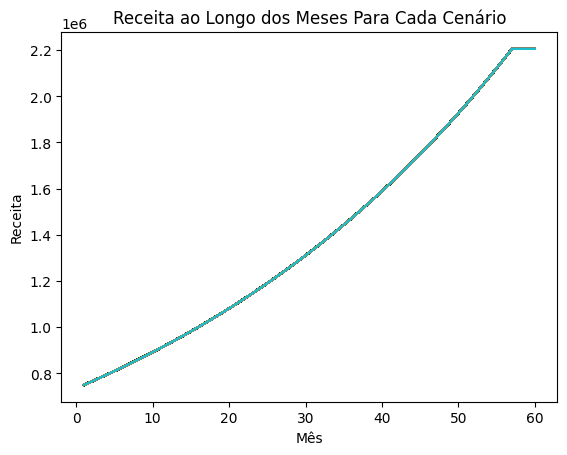

In [479]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

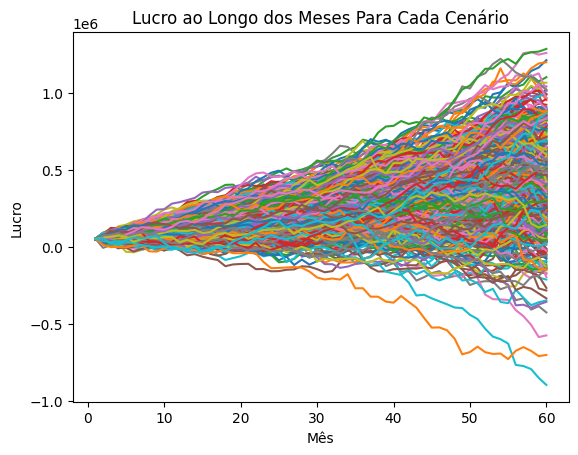

In [480]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

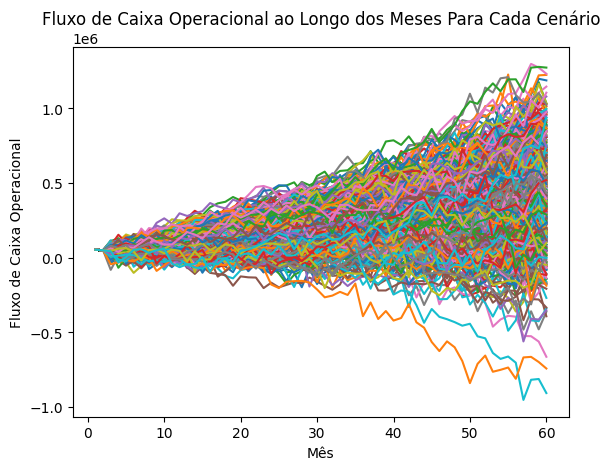

In [481]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

## Distribuição de FCO

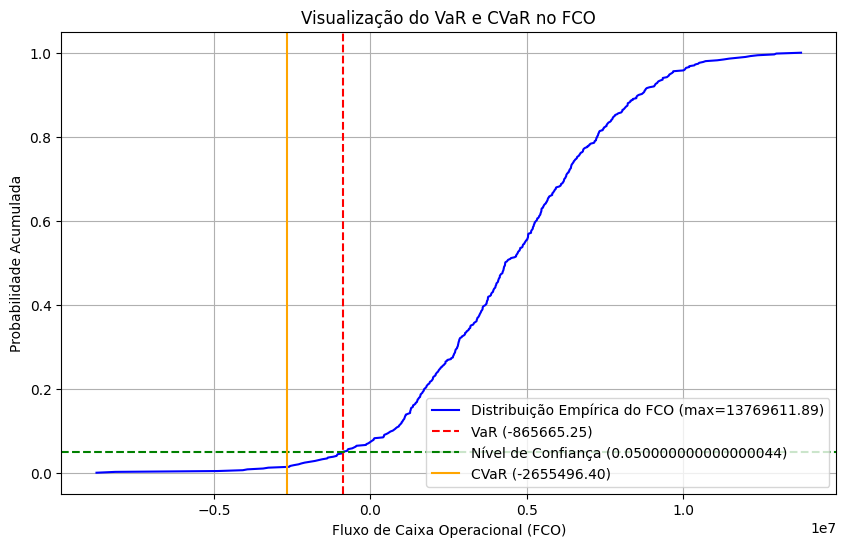

In [482]:
fco_values = [-value(model.FCO[i]) for i in S]

# descbrir var e cvar por cálculo, não utilizar model.VaR
var_value = sorted(fco_values)[int(len(fco_values) * 0.05)]
cvar_value = sum([fco for fco in fco_values if fco < var_value]) / int(len(fco_values) * 0.05)
alpha=0.95

import matplotlib.pyplot as plt
import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label=f'Distribuição Empírica do FCO (max={round(max(fco_values), 2)})', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({1-alpha})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO')
plt.xlabel('Fluxo de Caixa Operacional (FCO)')
plt.ylabel('Probabilidade Acumulada')
plt.legend()
plt.grid(True)

# Exibir
plt.show()

## Valores das 2 funções objetivo

In [483]:
print(f'Valor da Função Objetivo FCO: {model.objective()}')
print(f'Valor da Função NPV por GUROBI: {value(other_objective_rule(model))}')
print(f'Valor da Função NPV por Cálculo : {value(sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + GAMMA)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, T+1)))}')

Valor da Função Objetivo FCO: 4468706.033381695
Valor da Função NPV por GUROBI: 8653171.812769525
Valor da Função NPV por Cálculo : 8653171.812769525


# Modelo Estocástico Mono-objetivo | Valor Presente Líquido

In [484]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T=60

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=P_min)
model.Q = Var(range(1, T+1), bounds=(Q_min, 2*Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def other_objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def fco_rule_exp(model, i):
    t_final = T
    return -sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

def non_regression_rule(model, i, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmp0ea51wbz.pyomo.lp
Reading time = 0.12 seconds
x1: 60000 rows, 60 columns, 117000 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60000 rows, 60 columns and 117000 nonzeros
Model fingerprint: 0x305ea5d7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 1e+07]
  Bounds range     [1e+00, 2e+06]
  RHS range        [2e+05, 3e+05]
Presolve removed 59886 rows and 2 columns
Presolve time: 0.05s
Presolved: 114 rows, 58 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1932571e+07   4.350287e+05   0.000000e+00      0s
      55    8.6531718e+06   0.000000e+00   0.000000e+00      0s

Solved in 55 

## Quantidade de Vendas por Período

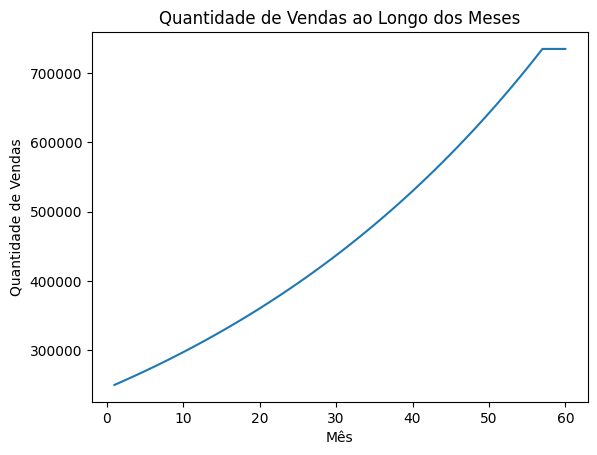

[250000, 254861.50000000003, 259817.53672900004, 264869.9485482322, 270020.6095677012, 275271.4303413547, 280624.35857577267, 286081.3798526372, 291644.5183652516, 297315.8376693823, 303097.44144870114, 308991.4742951126, 315000.1225042554, 321125.61488647317, 327370.22359355557, 333736.2649615559, 340226.1003699983, 346842.1371177933, 353586.82931618596, 360462.67879906856, 367472.23605099524, 374618.1011532429, 381902.9247482689, 389329.4090229238, 396900.3087107836, 404618.43211397354, 412486.6421448619, 420507.85738801095, 428685.05318277824, 437021.2627269706, 445519.5782019593, 454183.15191967465, 463015.19749190466, 472018.9910223323, 481197.8723217526, 490555.2461469214, 500094.5834634945, 509819.42273352563, 519733.3712280018, 529840.1063649015, 540143.3770732734, 550647.0051838403, 561354.8868466453, 572270.9939762652, 583399.3757251276, 594744.1599854785, 606309.5549205561, 618099.8505255413, 630119.4202188611, 642372.7224644371, 654864.3024254807, 667598.7936504466, 680580.

In [485]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

print([model.Q[t].value for t in range(1, T+1)])

## Receita por Período

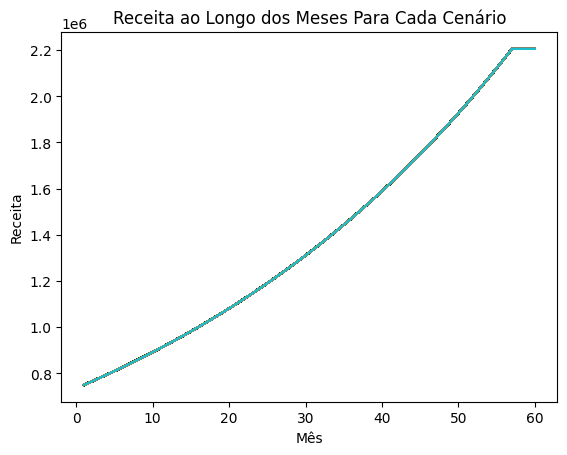

In [486]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

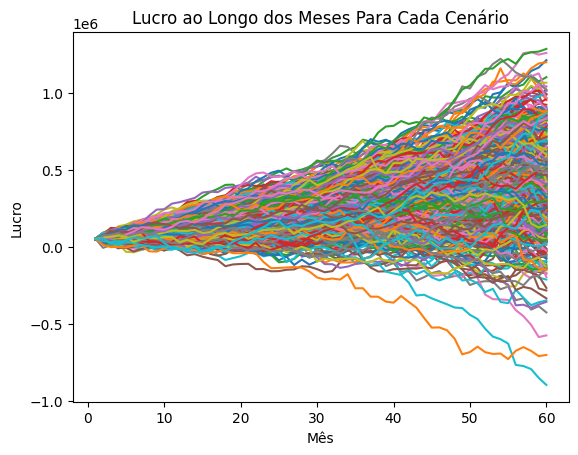

In [487]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

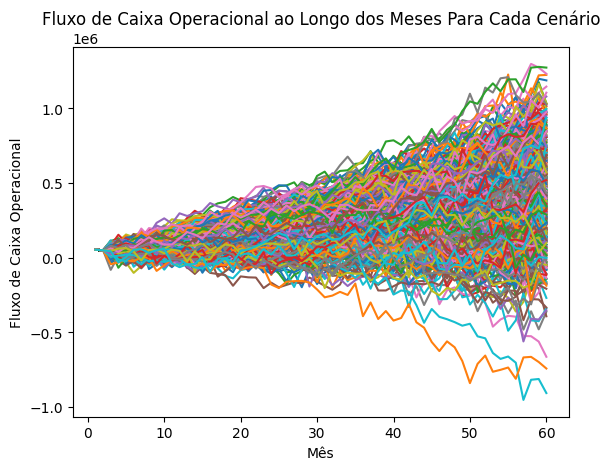

In [488]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

## Distribuição de FCO

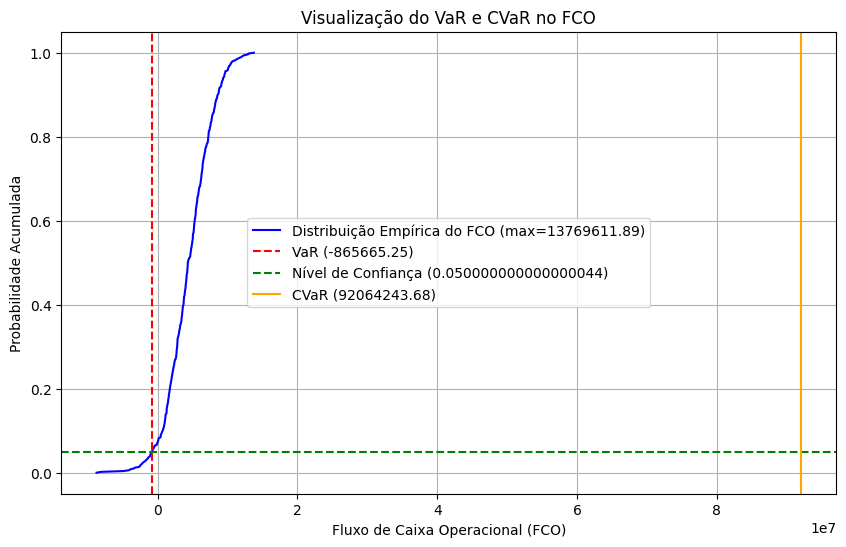

In [489]:
fco_values = [-value(model.FCO[i]) for i in S]

# descbrir var e cvar por cálculo, não utilizar model.VaR
var_value = sorted(fco_values)[int(len(fco_values) * 0.05)]
cvar_value = sum([fco for fco in fco_values if fco > var_value]) / int(len(fco_values) * 0.05)
alpha=0.95

import matplotlib.pyplot as plt
import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label=f'Distribuição Empírica do FCO (max={round(max(fco_values), 2)})', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({1-alpha})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO')
plt.xlabel('Fluxo de Caixa Operacional (FCO)')
plt.ylabel('Probabilidade Acumulada')
plt.legend()
plt.grid(True)

# Exibir
plt.show()

## Valores das 2 funções objetivo

In [490]:
print(f'Valor da Função Objetivo NPV: {model.objective()}')
print(f'Valor da Função FCO por GUROBI: {value(other_objective_rule(model))}')
print(f'Valor da Função FCO por Cálculo : {sum(sum(fco_period(model, i, t) for i in range(1, scenarios+1))/scenarios for t in range(1, T+1))}')

Valor da Função Objetivo NPV: 8653171.812769525
Valor da Função FCO por GUROBI: 4468706.033381695
Valor da Função FCO por Cálculo : 12685051.824908137


# Modelo Estocástico Mono-objetivo | CVaR

In [491]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T=60
S = range(1, 500+1)  # Cenários

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=3)
model.Q = Var(range(1, T+1), bounds=(Q_min, 2*Q_max), within=NonNegativeReals)

# Variáveis para CVaR
model.VarDev = Var(S, within=NonNegativeReals)  # Desvio por cenário
model.VaR = Var(within=Reals)        # Valor em Risco (VaR)
model.CVaR = Var(within=Reals)       # CVaR

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def other_objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def non_regression_rule(model, i, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Restrições para o CVaR
# Restrição para desvio por cenário
def fco_rule_exp(model, i):
    t_final = T
    return -sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

def vardev_rule(model, i):
    return model.FCO[i] - model.VaR <= model.VarDev[i]

model.vardev_constraint = Constraint(S, rule=vardev_rule)

# Restrição para definição do CVaR
def cvar_rule(model):
    alpha=0.05
    return model.VaR + (1 / (len(S) * alpha)) * sum(model.VarDev[i] for i in S) == model.CVaR

model.cvar_constraint = Constraint(rule=cvar_rule)

# minimizar o CVaR
model.objective = Objective(expr=model.CVaR, sense=minimize)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpgc29_aa2.pyomo.lp
Reading time = 0.12 seconds
x1: 60501 rows, 562 columns, 125502 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60501 rows, 562 columns and 125502 nonzeros
Model fingerprint: 0x1aeb002b
Coefficient statistics:
  Matrix range     [2e-03, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+06]
  RHS range        [2e+05, 4e+06]
Presolve removed 59887 rows and 3 columns
Presolve time: 0.06s
Presolved: 614 rows, 559 columns, 7728 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.380e+05
 Factor NZ  : 1.397e+05 

## Quantidade de Vendas por Período

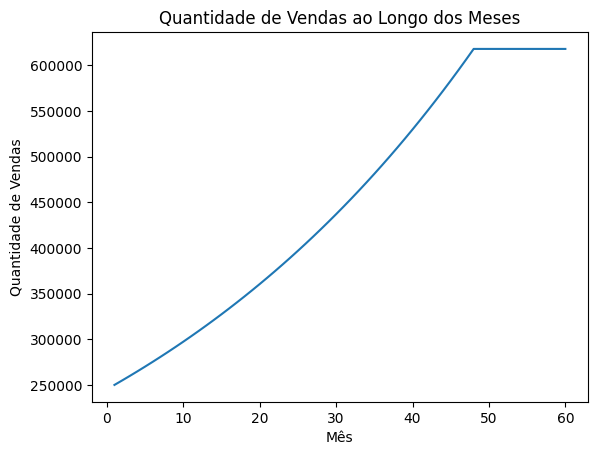

[250000, 254861.50000000003, 259817.53672900004, 264869.9485482322, 270020.6095677012, 275271.4303413547, 280624.35857577267, 286081.3798526372, 291644.5183652516, 297315.8376693823, 303097.44144870114, 308991.4742951126, 315000.1225042554, 321125.61488647317, 327370.22359355557, 333736.2649615559, 340226.1003699983, 346842.1371177933, 353586.82931618596, 360462.67879906856, 367472.23605099524, 374618.1011532429, 381902.9247482689, 389329.4090229238, 396900.3087107836, 404618.43211397354, 412486.6421448619, 420507.85738801095, 428685.05318277824, 437021.2627269706, 445519.5782019593, 454183.15191967465, 463015.19749190466, 472018.9910223323, 481197.8723217526, 490555.2461469214, 500094.5834634945, 509819.42273352563, 519733.3712280018, 529840.1063649015, 540143.3770732734, 550647.0051838403, 561354.8868466453, 572270.9939762652, 583399.3757251276, 594744.1599854785, 606309.5549205561, 618099.8505255413, 618099.8505255413, 618099.8505255413, 618099.8505255413, 618099.8505255413, 618099.

In [492]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

print([model.Q[t].value for t in range(1, T+1)])

## Receita por Período

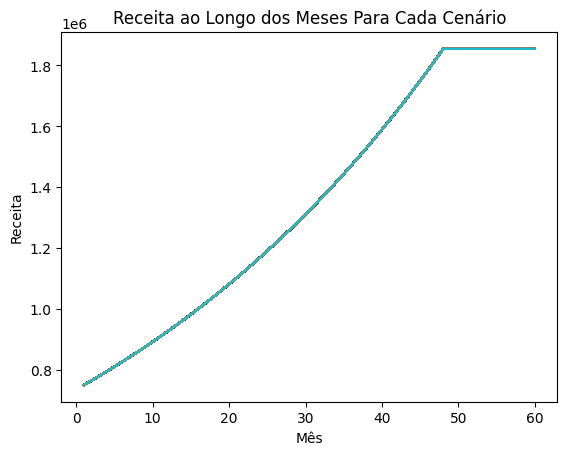

In [493]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

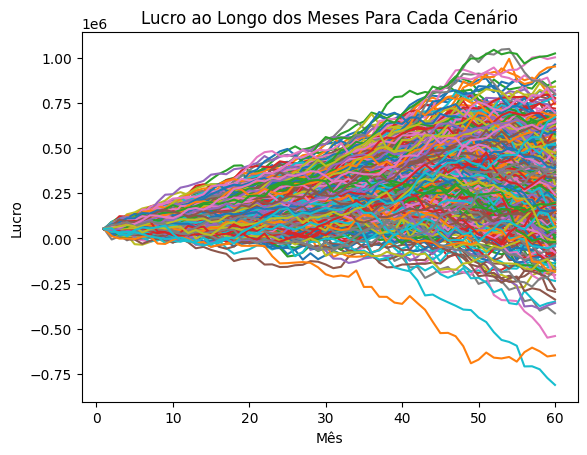

In [494]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

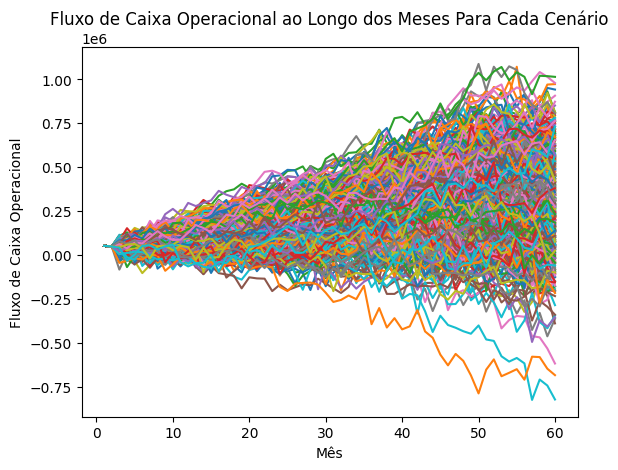

In [495]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

## Distribuição de FCO

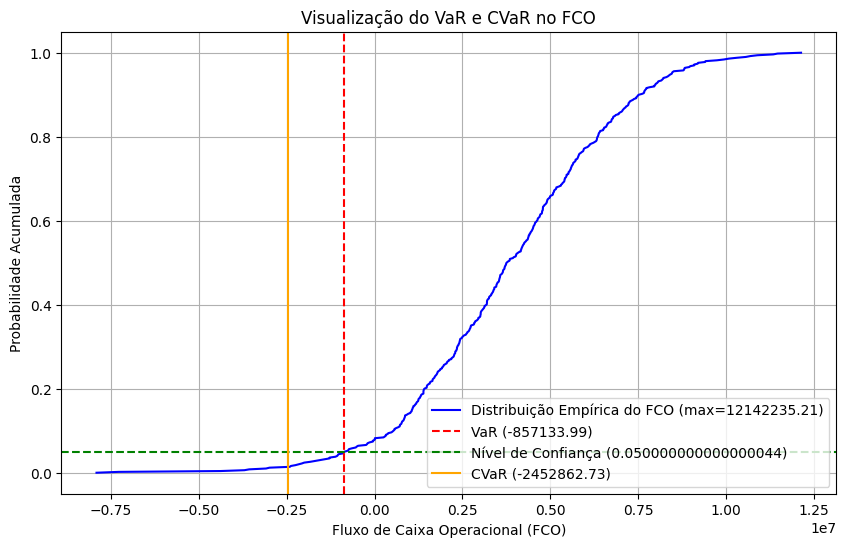

In [496]:
fco_values = [-value(model.FCO[i]) for i in S]

# descbrir var e cvar por cálculo, não utilizar model.VaR
var_value = sorted(fco_values)[int(len(fco_values) * 0.05)]
cvar_value = sum([fco for fco in fco_values if fco < var_value]) / int(len(fco_values) * 0.05)
alpha=0.95

import matplotlib.pyplot as plt
import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label=f'Distribuição Empírica do FCO (max={round(max(fco_values), 2)})', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({1-alpha})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO')
plt.xlabel('Fluxo de Caixa Operacional (FCO)')
plt.ylabel('Probabilidade Acumulada')
plt.legend()
plt.grid(True)

# Exibir
plt.show()

## Valores das 2 funções objetivo

In [497]:
print(f'Valor da Função Objetivo NPV: {model.objective()}')
print(f'Valor da Função FCO por GUROBI: {value(other_objective_rule(model))}')
print(f'Valor da Função FCO por Cálculo : {sum(sum(fco_period(model, i, t) for i in range(1, scenarios+1))/scenarios for t in range(1, T+1))}')

Valor da Função Objetivo NPV: 2452862.7320556883
Valor da Função FCO por GUROBI: 3872318.339900607
Valor da Função FCO por Cálculo : 12088664.13142705


# Criação da Fronteira Pareto - Problema Multi-objetivo

## Teste com CVaR

In [498]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T=60
S = range(1, scenarios+1)  # Cenários

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=P_min)
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Variáveis para CVaR
model.VarDev = Var(S, within=NonNegativeReals)  # Desvio por cenário
model.VaR = Var(within=Reals)        # Valor em Risco (VaR)
model.CVaR = Var(within=Reals)       # CVaR

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

def alternative_objective_net_present_value_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / ((1 + gamma)**t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def non_regression_rule(model, i, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Restrições para o CVaR
# Restrição para desvio por cenário
def fco_rule_exp(model, i):
    t_final = T
    return -sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

def vardev_rule(model, i):
    return model.FCO[i] - model.VaR <= model.VarDev[i]

model.vardev_constraint = Constraint(S, rule=vardev_rule)

# Restrição para definição do CVaR
def cvar_rule(model):
    alpha=0.05
    return model.VaR + (1 / (len(S) * alpha)) * sum(model.VarDev[i] for i in S) == model.CVaR

model.cvar_constraint = Constraint(rule=cvar_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Gerando ponto inicial e guardando
# model.objective = Objective(expr=objective_rule(model), sense=maximize)
# solver = SolverFactory('gurobi')
# solver.options['NonConvex'] = 2
# result = solver.solve(model, tee=True)
# objective_value = value(model.objective)


In [518]:
# OBJETIVO

solutions = []
pop_x = []

spaced = 100

for i, beta in enumerate(np.linspace(0.001, 1, spaced)):
    print(f'Iteration {i+1}/{spaced}')
    #  remove objective
    if i > 0:
        model.del_component(model.objective)
    model.objective = Objective(expr=-model.CVaR * beta + (1-beta)*objective_rule(model), sense=maximize)
    solver = SolverFactory('gurobi')
    # solver.options['NonConvex'] = 2
    result = solver.solve(model, tee=True, warmstart=True)
    # Beta, CVaR, FCO, NPV, Quantidade Final
    solutions.append((
        beta, 
        value(model.CVaR), 
        value(objective_rule(model)), 
        value(alternative_objective_net_present_value_rule(model)),
        value(model.Q[T])
    ))

    x_sol = []

    # 1) P_{i,t}
    #    model.P[i+1, t+1] no Pyomo => lembre-se que no Pyomo o i e t começam em 1..
    for i_scenario in range(scenarios):
        for t_period in range(T):
            x_sol.append(value(model.P))

    # 2) Q_t
    for t_period in range(T):
        x_sol.append(value(model.Q[t_period+1]))

    # 3) VarDev_i (se existir)
    for i_scenario in range(scenarios):
        # Se não estiver usando, pode colocar 0.0
        # ou, se estiver, use value(model.VarDev[i_scenario+1])
        x_sol.append(0.0)

    # 4) VaR e CVaR (2 vars extras)
    x_sol.append(value(model.VaR))
    x_sol.append(value(model.CVaR))

    pop_x.append(x_sol)


solutions


Iteration 1/100
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpw7j6vxwm.pyomo.lp
Reading time = 0.12 seconds
x1: 60501 rows, 562 columns, 125502 nonzeros
Read MIP start from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmp5jweqex3.gurobi.mst
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60501 rows, 562 columns and 125502 nonzeros
Model fingerprint: 0xde1f6a83
Coefficient statistics:
  Matrix range     [2e-03, 4e+00]
  Objective range  [1e-03, 4e+06]


[(0.001,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.011090909090909092,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.021181818181818184,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.03127272727272727,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.041363636363636366,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.05145454545454546,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.06154545454545455,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.07163636363636364,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.08172727272727273,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.09181818181818183,
  2655496.400304

## Plotagem da Fronteira Pareto

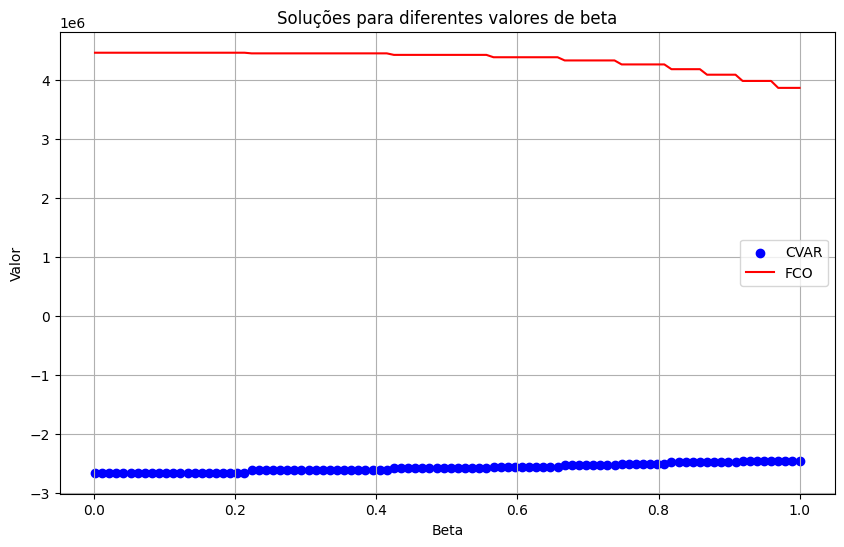

In [519]:
def plot_solutions(solutions):
    betas = [sol[0] for sol in solutions]
    CVAR = [-sol[1] for sol in solutions]
    FCO = [sol[2] for sol in solutions]

    plt.figure(figsize=(10, 6))
    plt.scatter(betas, CVAR, label='CVAR', color='blue')
    plt.plot(betas, FCO, label='FCO', color='red')

    plt.title('Soluções para diferentes valores de beta')
    plt.xlabel('Beta')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_solutions(solutions)

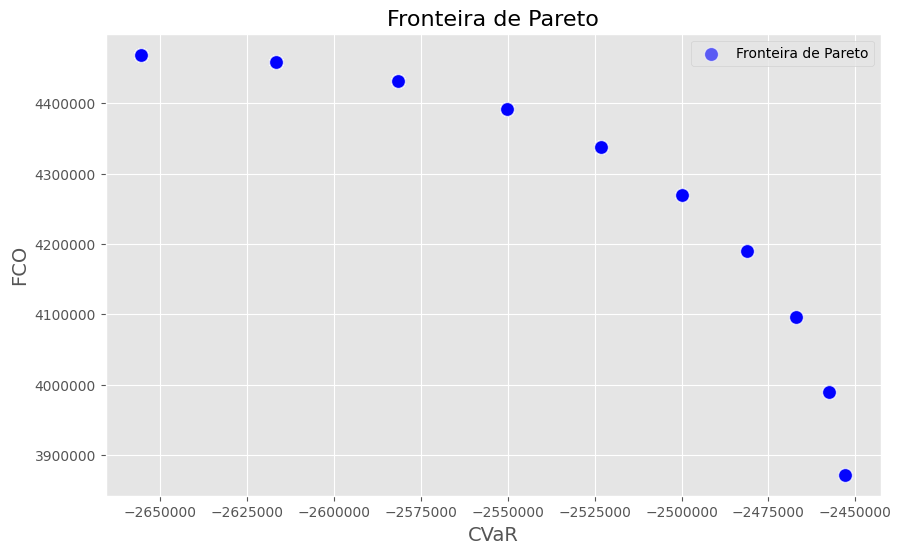

In [539]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pareto(solutions):
    plt.style.use('ggplot')
    figsize = (10, 6)
    marker_size = 100
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Converte as soluções para um array numpy para facilitar a manipulação
    solutions = np.array(solutions)
    
    # Plota os pontos da fronteira de Pareto usando seaborn
    sns.scatterplot(x=[-s for s in solutions[:, 1]], y=solutions[:, 2], color='blue', s=marker_size, alpha=0.6, edgecolor='w', label='Fronteira de Pareto', ax=ax)
    
    # Coloca os eixos como múltiplos de 10^6
    ax.ticklabel_format(axis='x', style='plain')
    ax.ticklabel_format(axis='y', style='plain')
    
    # Melhorias estéticas
    ax.set_xlabel('CVaR', fontsize=14)
    ax.set_ylabel('FCO', fontsize=14)
    ax.set_title('Fronteira de Pareto', fontsize=16)
    ax.legend()
    ax.grid(True)
    
    plt.show()
    
plot_pareto(solutions)

## Filtragem da Fronteira Pareto

In [521]:
filtered_solutions = []
filtered_pop_x = []

for i, sol in enumerate(solutions):
    if not any(sol[1] == s[1] and sol[2] == s[2] and sol[3] == s[3] and sol[4] == s[4] for s in filtered_solutions):
        filtered_solutions.append(sol)
        filtered_pop_x.append(pop_x[i])

filtered_solutions

[(0.001,
  2655496.400304947,
  4468706.033381695,
  8653171.812769525,
  735083.4992892854),
 (0.223,
  2616491.3748603165,
  4457789.8721641125,
  8647351.508402193,
  721061.7328326221),
 (0.4248181818181818,
  2581403.4482858144,
  4432052.8856338,
  8633305.359401781,
  707307.4325002227),
 (0.5660909090909091,
  2550216.5038024522,
  4391922.72392995,
  8611185.530670024,
  693815.4963580441),
 (0.667,
  2523035.495962988,
  4337814.365648499,
  8581139.486545412,
  680580.9197917732),
 (0.7477272727272728,
  2500005.763365728,
  4270170.431492527,
  8543333.664072545,
  667598.7936504466),
 (0.8183636363636364,
  2481292.301131106,
  4189390.878314048,
  8497912.168296773,
  654864.3024254807),
 (0.8688181818181818,
  2467147.692707802,
  4095865.1042870968,
  8445015.444843138,
  642372.7224644371),
 (0.9192727272727274,
  2457600.086945987,
  3990045.0907757618,
  8384824.659643084,
  630119.4202188611),
 (0.9697272727272728,
  2452862.7320556883,
  3872318.339900607,
  831748

# Tomada de Decisão

## Variáveis de Decisão

Para a tomada de decisão, é necessário definir as variáveis de decisão que serão utilizadas para a resolução do problema. As variáveis de decisão são as variáveis que podem ser controladas pelo tomador de decisão e que influenciam o resultado do problema. No caso do problema proposto, as variáveis de decisão são:

- FCO dos últimos 12 Meses
- Valor Presente Líquido
- CVaR
- Quantidade de vendas por período

## Algoritmo de Decisão
Em um primeiro momento, será utilizada a abordagem de definição de Pesos pelo AHP e a execução do método TOPSIS para a tomada de decisão. Posteriormente, a abordagem estendida de Bellman-Zadeh será utilizada para a tomada de decisão.

In [528]:
import numpy as np
from tabulate import tabulate


m = 344    # número de alternativas
n = 3      # número de critérios

# Definir os critérios do problema
criterios = ["CVaR (C1)", "FCO (C2)", "NPV (C3)", "Quantidade Final (C4)"]

# Matriz de comparação entre os critérios
# Substitua pelos valores do seu problema
comparison_matrix = np.array([
    [1,   3, 4, 4],  # C1 é 3x mais importante que C2, 4 vezes mais que C3 e 4 vezes mais que C4
    [1/3, 1, 2, 2],  # C2 é 3 vezes menos importante que C1, 2 vezes mais que C3 e 2 vezes mais que C4
    [1/4, 1/2, 1, 1],  # C3 é 4 vezes menos importante que C1, 2 vezes menos que C2 e igual a C4
    [1/4, 1/2, 1, 1]   # C4 é 4 vezes menos importante que C1, 2 vezes menos que C2 e igual a C3
], dtype=float)

# Normalizar
column_sums = np.sum(comparison_matrix, axis=0)          # soma de cada coluna
normalized_matrix = comparison_matrix / column_sums      # normaliza cada coluna
pesos = np.mean(normalized_matrix, axis=1)    

pesos_utilizados = pesos

pesos

array([0.53636364, 0.22045455, 0.12159091, 0.12159091])

           A1         A2         A3        A4         A5         A6         A7         A8         A9       A10
---  --------  ---------  ---------  --------  ---------  ---------  ---------  ---------  ---------  --------
A1   0         0.127734   0.142336   0.165182  0.196066   0.234765   0.281077   0.334809   0.395727   0.463636
A2   0.103245  0          0.136192   0.159039  0.189923   0.228621   0.274934   0.328665   0.389584   0.457493
A3   0.196121  0.0928763  0          0.144437  0.175321   0.21402    0.260332   0.314064   0.374982   0.442891
A4   0.278671  0.175427   0.0825505  0         0.152475   0.191174   0.237486   0.291218   0.352136   0.420045
A5   0.350618  0.247374   0.154498   0.071947  0          0.160289   0.206602   0.260334   0.321252   0.389161
A6   0.411577  0.308332   0.215456   0.132906  0.0609587  0          0.167903   0.221635   0.282553   0.350463
A7   0.461111  0.357866   0.26499    0.182439  0.110492   0.0495337  0          0.175323   0.236241   0.30415
A8

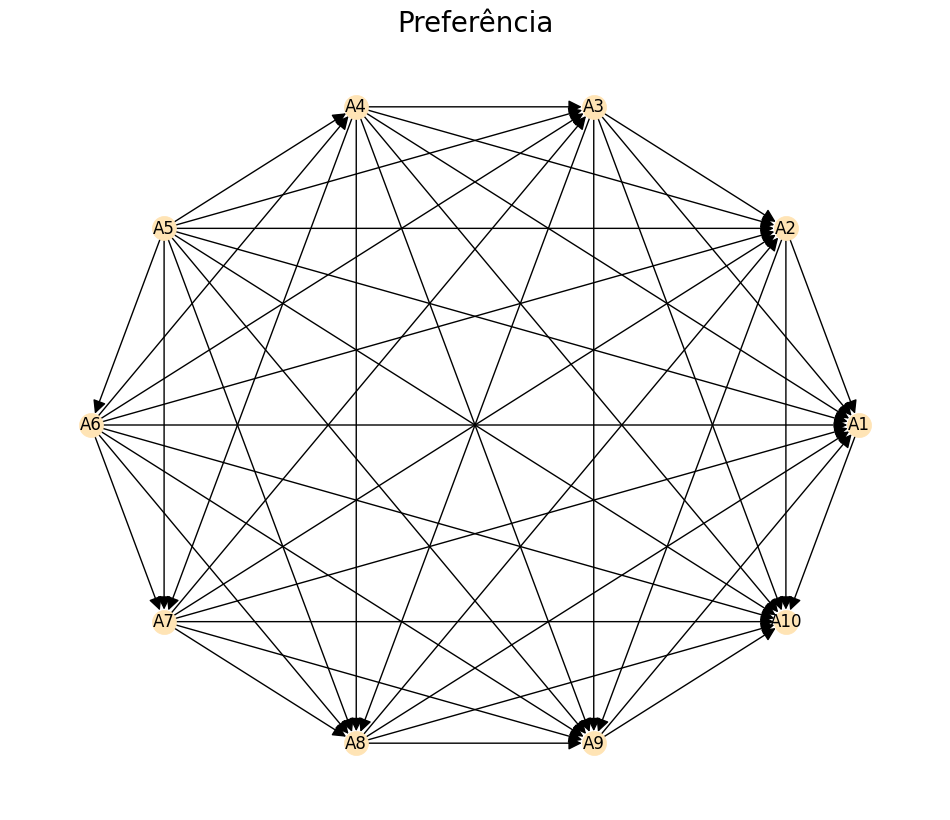

/Users/henriquealvesbarbosa/opt/anaconda3/envs/onl/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:315: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


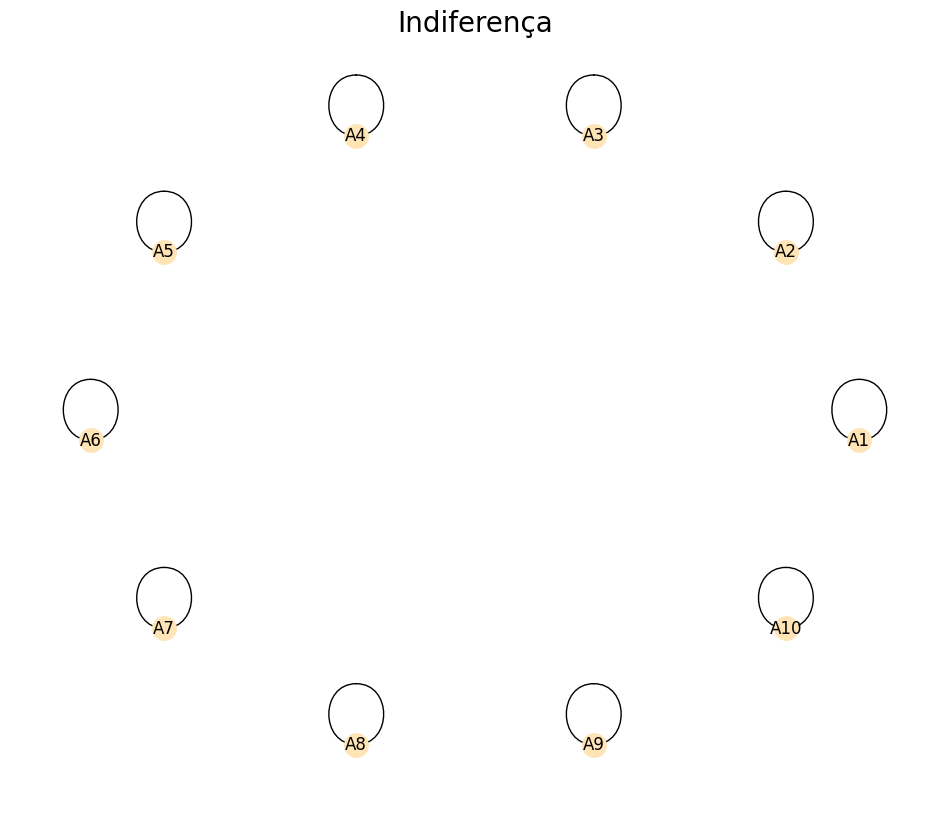

In [535]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate

# Exemplo de listas para critérios (substitua pelos dados do seu problema)
criterio_1 = [-s[1] for s in filtered_solutions]  # CVaR (vem positivo, mas é negativo)
criterio_2 = [s[2] for s in filtered_solutions]  # FCO
criterio_3 = [s[3] for s in filtered_solutions]  # NPV
criterio_4 = [s[4] for s in filtered_solutions]  # Quantidade Final

# Número de alternativas e critérios
n_alternativas = len(criterio_1)
n_criterios = 4

# Matriz de critérios
criterios = np.array([criterio_1, criterio_2, criterio_3, criterio_4]).T

# Funções de avaliação para os critérios
def G1(x):  # Critério 1: Maximizar (linear)
    # CVaR entre -2655496 e -2452862 - Diferença entre -202634 e +202634
    p = 202634
    return max(0.0, min(1.0, x / p))

def G2(x):  # Critério 2: Maximizar (linear)
    # FCO entre 4468706 e 3872318 - Diferença entre 596388 e -596388
    p = 596388
    return max(0.0, min(1.0, x / p))

def G3(x):  # Critério 3: Maximizar (linear)
    # Custo entre 8653171 e 8317484 - Diferença entre 335687 e -335687
    p = 335687
    return max(0.0, min(1.0, x / p))

def G4(x):  # Critério 4: Maximizar (usual)
    # QOA entre 0 e 1; Simplesmente retornar o valor
    return 1.0 if x > 0.0 else 0.0

# Pesos dos critérios
pesos = pesos_utilizados

# Construção da matriz de preferências parciais
Pj = np.zeros((n_alternativas, n_alternativas, n_criterios))
for i in range(n_alternativas):
    for k in range(n_alternativas):
        for j in range(n_criterios):
            diff = criterios[i, j] - criterios[k, j]
            if j == 0:
                Pj[i, k, j] = G1(diff)
            elif j == 1:
                Pj[i, k, j] = G2(diff)
            elif j == 2:
                Pj[i, k, j] = G3(diff)
            else:
                Pj[i, k, j] = G4(diff)

# Construção da matriz de preferências agregadas
P = np.zeros((n_alternativas, n_alternativas))
for i in range(n_alternativas):
    for k in range(n_alternativas):
        P[i, k] = np.sum(pesos * Pj[i, k, :])

# Exibição da matriz de preferências agregadas
headers = [f"A{i+1}" for i in range(n_alternativas)]
print(tabulate(([headers[i]] + P[i, :].tolist() for i in range(n_alternativas)), headers=headers))

# Fluxos positivos, negativos e finais
phip = np.sum(P, axis=1)  # Fluxo positivo
phim = np.sum(P, axis=0)  # Fluxo negativo
phi = phip - phim         # Fluxo final

# Exibição dos fluxos
print("\nFluxos Positivos:", phip)
print("Fluxos Negativos:", phim)
print("Fluxos Finais:", phi)

# Construção dos grafos de preferências e indiferenças
Pf = phi[:, None] > phi  # Preferência
If = phi[:, None] == phi  # Indiferença

# Grafo de preferência (direcionado)
fig_pref, ax_pref = plt.subplots(figsize=[12, 10])
grafo_pref = nx.DiGraph(Pf)
nx.draw_circular(grafo_pref,
                 ax=ax_pref,
                 arrowsize=20,
                 with_labels=True,
                 labels={i: f"A{i+1}" for i in range(n_alternativas)},
                 node_color='moccasin')
ax_pref.set_title("Preferência", fontsize=20)
plt.show()

# Grafo de indiferença (não-direcionado)
fig_indif, ax_indif = plt.subplots(figsize=[12, 10])
grafo_indif = nx.Graph(If)
nx.draw_circular(grafo_indif,
                 ax=ax_indif,
                 arrowsize=20,
                 with_labels=True,
                 labels={i: f"A{i+1}" for i in range(n_alternativas)},
                 node_color='moccasin')
ax_indif.set_title("Indiferença", fontsize=20)
plt.show()


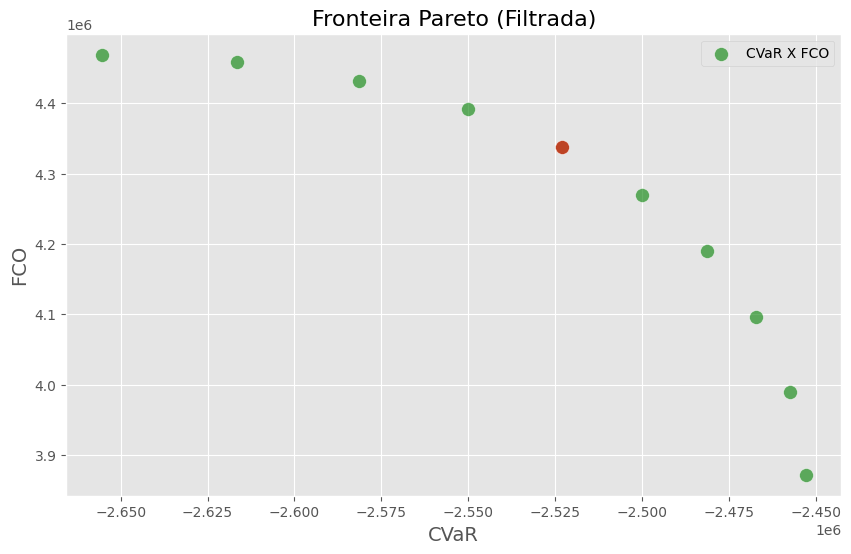

In [540]:
plt.style.use('ggplot')
figsize = (10, 6)
marker_size = 100

fig2, ax2 = plt.subplots(figsize=figsize)
scatter2 = ax2.scatter(criterio_1, criterio_2, c='green', s=marker_size, alpha=0.6, edgecolors='w', label='CVaR X FCO')
ax2.set_ylabel("FCO", fontsize=14)
ax2.set_xlabel("CVaR", fontsize=14)
ax2.set_title("Fronteira Pareto (Filtrada)", fontsize=16)
ax2.legend()
ax2.grid(True)

# Marcar ponto com [Prioridade, Custo] = [prioridades[19], custos[19]]
ax2.scatter(criterio_1[4], criterio_2[4], c='red', s=marker_size, alpha=0.6, edgecolors='w', label='Solução Ideal')

# Exibir o gráfico
plt.show()

# Utilização do PyMoo

## Utilizando o NSGA-II sozinho

In [537]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination


class StochasticMultiobjectiveProblem(Problem):
    def __init__(
            self,
            scenarios, T,
            P_min, P_max,
            Q_min, Q_max,
            variable_cost_percentage,
            variable_expenses_percentage,
            taxes_percentage,
            fix_costs,
            fix_expenses,
            theta_AR, theta_I, theta_AP,
            initial_NCG,
            initial_investment,
            growth_rate,
            profit_increment_rate,
            a, b,
            initial_quantity,
            months_future_FCO,
    ):
        self.scenarios = scenarios
        self.T = T
        self.P_min = P_min
        self.P_max = P_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        self.variable_cost_percentage = variable_cost_percentage
        self.variable_expenses_percentage = variable_expenses_percentage
        self.taxes_percentage = taxes_percentage
        self.fix_costs = fix_costs
        self.fix_expenses = fix_expenses
        self.theta_AR = theta_AR
        self.theta_I = theta_I
        self.theta_AP = theta_AP
        self.initial_NCG = initial_NCG
        self.initial_investment = initial_investment
        self.growth_rate = growth_rate
        self.profit_increment_rate = profit_increment_rate
        self.a = a
        self.b = b
        self.initial_quantity = initial_quantity
        self.months_future_FCO = months_future_FCO

        # Quantidade de variáveis de decisão:
        #  P_{i,t} : S*T
        #  Q_t     : T
        #  VarDev_i: S
        #  VaR, CVaR: 2
        self.nP = scenarios * T
        self.nQ = T
        self.nVarDev = scenarios
        self.nTotal = self.nP + self.nQ + self.nVarDev + 2  # + VaR + CVaR

        # Limites inferiores (xl) e superiores (xu)
        lb_P = np.full(self.nP, P_min)
        ub_P = np.full(self.nP, P_max)

        lb_Q = np.full(self.nQ, Q_min)
        ub_Q = np.full(self.nQ, Q_max)

        lb_VarDev = np.full(self.nVarDev, 0.0)   
        ub_VarDev = np.full(self.nVarDev, 1e15)  

        lb_extra = np.array([-1e15, -1e15])  # VaR, CVaR sem limite inferior real
        ub_extra = np.array([+1e15, +1e15])

        xl = np.concatenate([lb_P, lb_Q, lb_VarDev, lb_extra])
        xu = np.concatenate([ub_P, ub_Q, ub_VarDev, ub_extra])

        # --------------------------------------------------------
        # Quantas constraints ao todo?
        # --------------------------------------------------------
        # (a) fco_rule(i,t): S*T
        # (b) demand_rule(i,t): 2*S*T (igualdade => 2 ineq)
        # (c) growth_rule(i,t): S*(T-1)
        # (d) profit_rule(i,t): S*(T-2) (se T>2)
        n_fco      = self.scenarios * self.T
        n_demand   = 2 * self.scenarios * self.T
        n_demand = 0
        n_growth   = self.scenarios * max(0, (self.T - 1))
        n_profit   = self.scenarios * max(0, (self.T - 2))
        n_constr   = n_fco + n_demand + n_growth + n_profit

        super().__init__(
            n_var=self.nTotal,
            n_obj=2,         # -objective_rule e CVaR
            n_constr=n_constr,
            xl=xl,
            xu=xu
        )

    # ----------------
    # Índices
    # ----------------
    def _index_p(self, i, t):
        return i*self.T + t

    def _index_q(self, t):
        return self.nP + t

    def _index_vardev(self, i):
        return self.nP + self.nQ + i

    def _index_var(self):
        return self.nP + self.nQ + self.nVarDev

    def _index_cvar(self):
        return self.nP + self.nQ + self.nVarDev + 1

    # ----------------
    # Auxiliares
    # ----------------
    def revenue_rule(self, P_it, Q_t):
        return P_it * Q_t

    def AR_rule(self, P_it, Q_t):
        return self.revenue_rule(P_it, Q_t) * self.theta_AR

    def I_rule(self, i, t, P_it, Q_t):
        return (self.variable_cost_percentage[i, t] * self.revenue_rule(P_it, Q_t)) * self.theta_I

    def AP_rule(self, i, t, P_it, Q_t, I_t, I_t_minus_1):
        return (I_t + self.variable_cost_percentage[i, t] * self.revenue_rule(P_it, Q_t) - I_t_minus_1) * self.theta_AP

    def NCG_rule(self, i, t, x):
        idx_pit = self._index_p(i, t)
        P_it = x[idx_pit]
        idx_qt = self._index_q(t)
        Q_t = x[idx_qt]

        AR_t = self.AR_rule(P_it, Q_t)
        I_t = self.I_rule(i, t, P_it, Q_t)

        if t == 0:
            I_t_minus_1 = self.initial_investment
        else:
            idx_p_i_t_1 = self._index_p(i, t-1)
            P_i_t_1 = x[idx_p_i_t_1]
            idx_q_t_1 = self._index_q(t-1)
            Q_t_1 = x[idx_q_t_1]
            I_t_minus_1 = self.I_rule(i, t-1, P_i_t_1, Q_t_1)

        AP_t = self.AP_rule(i, t, P_it, Q_t, I_t, I_t_minus_1)
        current = AR_t + I_t - AP_t

        if t == 0:
            previous = self.initial_NCG
        else:
            # AR(t-1) + I(t-1) - AP(t-1)
            idx_p_i_t_1 = self._index_p(i, t-1)
            P_i_t_1 = x[idx_p_i_t_1]
            idx_q_t_1 = self._index_q(t-1)
            Q_t_1 = x[idx_q_t_1]
            AR_t_1 = self.AR_rule(P_i_t_1, Q_t_1)
            I_t_1 = self.I_rule(i, t-1, P_i_t_1, Q_t_1)

            if (t-1) == 0:
                AP_t_1 = self.AP_rule(i, 0, P_i_t_1, Q_t_1, I_t_1, self.initial_investment)
            else:
                idx_p_i_t_2 = self._index_p(i, t-2)
                P_i_t_2 = x[idx_p_i_t_2]
                idx_q_t_2 = self._index_q(t-2)
                Q_t_2 = x[idx_q_t_2]
                I_t_2 = self.I_rule(i, t-2, P_i_t_2, Q_t_2)
                AP_t_1 = self.AP_rule(i, t-1, P_i_t_1, Q_t_1, I_t_1, I_t_2)

            previous = AR_t_1 + I_t_1 - AP_t_1

        return current - previous

    def monthly_profit(self, i, t, x):
        idx_pit = self._index_p(i, t)
        P_it = x[idx_pit]
        idx_qt = self._index_q(t)
        Q_t = x[idx_qt]
        rev = self.revenue_rule(P_it, Q_t)
        return (
            rev
            - self.variable_cost_percentage[i, t] * rev
            - self.variable_expenses_percentage * rev
            - self.taxes_percentage * rev
            - self.fix_costs
            - self.fix_expenses
        )

    def fco_rule(self, i, t, x):
        return self.monthly_profit(i, t, x) - self.NCG_rule(i, t, x)

    def final_fco_sum(self, i, x):
        start_t = self.T - self.months_future_FCO
        total = 0.0
        for t in range(start_t, self.T):
            total += self.fco_rule(i, t, x)
        return total

    def discounted_fco_sum(self, i, x):
        start_t = 0
        total = 0.0
        for t in range(0, self.T):
            total += (self.fco_rule(i, t-1, x) / (1 + GAMMA)**t)
        return total

    def objective_rule(self, x):
        # soma final fco nos últimos meses, e faz a média
        total = 0.0
        for i in range(self.scenarios):
            total += self.final_fco_sum(i, x)
        return total / self.scenarios
    
    def alternate_objective_rule(self, x):
        # soma final fco nos últimos meses, e faz a média
        total = 0.0
        for i in range(self.scenarios):
            total += self.discounted_fco_sum(i, x)
        return total / self.scenarios


    # =======================================================================
    # AQUI: mude de "evaluate" para "_evaluate"
    # =======================================================================
    def _evaluate(self, X, out, *args, **kwargs):
        # X pode ter shape (pop_size, n_var) ou (n_var,)
        if X.ndim == 1:
            X = X[None, :]

        n_ind = X.shape[0]
        
        # Prepara saidas
        F = np.zeros((n_ind, 2))  # 2 objetivos
        G = np.zeros((n_ind, self.n_constr))  # constraints

        for k in range(n_ind):
            xk = X[k, :]

            # ------------------------
            # Objetivos
            # ------------------------
            # 1) Maximize objective_rule -> minimize -objective_rule
            obj_rule = self.objective_rule(xk)
            F[k, 0] = -obj_rule

            # 2) Minimizar CVaR
            alternative_objective_net_present_value_rule = self.alternate_objective_rule(xk)
            F[k, 1] = -alternative_objective_net_present_value_rule

            # ------------------------
            # Restrições
            # ------------------------
            # Montamos uma lista e depois jogamos em G[k,:]
            g_list = []

            eps_tol = 0

            # (a) fco_rule(i,t) >= 0 => -fco_rule(i,t) <= 0
            for i in range(self.scenarios):
                for t in range(self.T):
                    fco_it = self.fco_rule(i, t, xk)
                    g_list.append(-fco_it)  # <= 0

            # (b) demand_rule: P_{i,t} = a - b*Q_t => 2 ineq
            for i in range(self.scenarios):
                for t in range(self.T):
                    P_it = xk[self._index_p(i, t)]
                    Q_t = xk[self._index_q(t)]
                    expr = P_it - (self.a - self.b * Q_t)
                    # expr = 0 => expr <=0 and -expr <=0
                    # g_list.append(expr)      # <= 0
                    # g_list.append(-expr)     # <= 0

            # (c) growth_rule: Q[t] <= growth_rate * Q[t-1]
            #                 => Q[t] - growth_rate * Q[t-1] <= 0
            if self.T > 1:
                for i in range(self.scenarios):
                    for t in range(1, self.T):
                        Qt = xk[self._index_q(t)]
                        Qtm1 = xk[self._index_q(t-1)]
                        g_list.append(Qt - self.growth_rate * Qtm1)

            # (d) profit_rule:
            #    se t<=2 => sem restrição
            #    caso contrário => profit(i,t) >= profit(i,t-1)*rate => => -(profit(t) - profit(t-1)*rate) <=0
            #    Lembrando que t Pyomo=1..T, mas aqui t=0..T-1. Então "t<=2" em Pyomo ~ "t<=1" aqui (deslocando 1).
            for i in range(self.scenarios):
                # Precisamos checar do t=2 (Pyomo) -> t=1 (nosso 0-based)
                # Mas o seu Pyomo faz if t<=2 => sempre True => sem restrição
                # => restrição começa em t>=3 => no 0-based, t>=2
                # Então laço t=2..(T-1)
                for t in range(2, self.T):
                    profit_t = self.monthly_profit(i, t, xk)
                    profit_t_minus_1 = self.monthly_profit(i, t-1, xk)
                    g_list.append(-(profit_t - profit_t_minus_1*self.profit_increment_rate))

            G[k, :] = np.array(g_list)

        out["F"] = F
        out["G"] = G


# ================
# EXEMPLO DE USO
# ================
if __name__ == "__main__":
    # Número de meses
    T=60

    # Parâmetros
    a = 60  # Constante da demanda
    b = 1/2000    # Elasticidade da demanda
    variable_cost_percentage = 0.35  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
    variable_expenses_percentage = 0.03  # Percentual de custos variáveis
    taxes_percentage = 0.07  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
    CF = 112_500    # Custo fixo mensal (salários, aluguel, etc)
    DF = 247_500    # Despesa fixa mensal
    theta_AR = 35/30 # 35 dias de recebimento
    theta_I = 30/30 # 30 dias de estoque
    theta_AP = 30/30 # 30 dias de pagamento

    # Intervalos de preço e quantidade
    P_min = 3 # 3 reais por lata
    P_max = 3
    Q_min = 250_000 # 250.000 latas
    inital_sales = 250_000 # Vendas iniciais
    Q_max = 450_000

    # Variação inicial da NCG (exemplo)
    initial_NCG = 875_000 + 262_500 - 262_500 #CR + Estoque Inicial - CP
    initial_inventory = 262_500 # 

    # Meses usados no cálculo do FCO futuro
    months_future_FCO = 12

    # Taxa de Incremento do Lucro
    profit_increment_rate = 0.8 #0.7
    growth_rate = 1.019446 # 1.26 a.a

    # Value at risk
    alpha_var = 0.05
    epsilon_var = 10000  # Valor inicial, será atualizado no loop

    # Taxa de Desconto
    GAMMA = 0.01

    problem = StochasticMultiobjectiveProblem(
        scenarios=scenarios,
        T=T,
        P_min=P_min, P_max=P_max,
        Q_min=Q_min, Q_max=Q_max,
        variable_cost_percentage=variable_cost_percentage,
        variable_expenses_percentage=variable_expenses_percentage,
        taxes_percentage=taxes_percentage,
        fix_costs=CF,
        fix_expenses=DF,
        theta_AR=theta_AR,
        theta_I=theta_I,
        theta_AP=theta_AP,
        initial_NCG=initial_NCG,
        initial_investment=initial_inventory,
        growth_rate=growth_rate,
        profit_increment_rate=profit_increment_rate,
        a=a, b=b,
        initial_quantity=inital_sales,
        months_future_FCO=months_future_FCO,
    )

    # Algoritmo de otimização
    algorithm = NSGA2(pop_size=50)

    # Critério de parada
    termination = get_termination("n_gen", 5)

    # Rodar otimização
    # res = minimize(problem, algorithm, termination, verbose=True)


In [538]:
# Análise de Consistência

# 1) Verificar se a fronteira de Pareto é consistente com o esperado

# Pegar init_pop = np.array(pop_x) e calcular nos objetivos do problema

init_pop = np.array(pop_x)

F = np.zeros((init_pop.shape[0], 2))
G = np.zeros((init_pop.shape[0], problem.n_constr))

for k in range(init_pop.shape[0]):
    xk = init_pop[k, :]
    evaluation = problem.evaluate(xk, return_values_of=["F", "G"])
    F[k, :] = evaluation[0]  # Supondo que "F" seja o primeiro elemento da tupla
    G[k, :] = evaluation[1]  # Supondo que "G" seja o segundo elemento da tupla

# 2) Verificar se as restrições são satisfeitas

# Se G[k, :] for tudo zero, então a solução é factível
# Se G[k, :] for diferente de zero, então a solução é infactível

for k in range(init_pop.shape[0]):
    if np.all(G[k, :] < 1e-6):
        print(f"Solução {k} é factível")
    else:
        print(f"Solução {k} é infactível por conta das restrições {np.where(G[k, :] > 1e-6)}")

# 3) Verificar se a fronteira de Pareto é consistente com o esperado

plt.figure(figsize=(10, 6))
plt.plot(F[:, 0], F[:, 1], color='blue', marker='o', linestyle='-', label='Fronteira de Pareto')
plt.xlabel('FCO')
plt.ylabel('CVaR')
plt.title('Fronteira de Pareto')
plt.grid(True)
plt.legend()
plt.show()

TypeError: 'float' object is not subscriptable

## Análise das Soluções

In [ ]:
# # Plot pareto

# import matplotlib.pyplot as plt

# F = res.F

# plt.figure(figsize=(10, 6))
# plt.scatter(F[:, 0], F[:, 1], color='blue', marker='o', s=30)
# plt.xlabel('FCO')
# plt.ylabel('NPV')
# plt.title('Fronteira de Pareto')
# plt.grid(True)
# plt.show()



## Utilizando as soluções inicialmente encontradas como ponto de partida para o NSGA-II

In [ ]:
import pyomo as pyo

# Número de meses
T=60

# Parâmetros
a = 60  # Constante da demanda
b = 1/2000    # Elasticidade da demanda
variable_cost_percentage = 0.35  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
variable_expenses_percentage = 0.03  # Percentual de custos variáveis
taxes_percentage = 0.07  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
CF = 112_500    # Custo fixo mensal (salários, aluguel, etc)
DF = 247_500    # Despesa fixa mensal
theta_AR = 35/30 # 35 dias de recebimento
theta_I = 30/30 # 30 dias de estoque
theta_AP = 30/30 # 30 dias de pagamento

# Intervalos de preço e quantidade
P_min = 3 # 3 reais por lata
P_max = 3
Q_min = 250_000 # 250.000 latas
inital_sales = 250_000 # Vendas iniciais
Q_max = 450_000

# Variação inicial da NCG (exemplo)
initial_NCG = 875_000 + 262_500 - 262_500 #CR + Estoque Inicial - CP
initial_inventory = 262_500 # 

# Meses usados no cálculo do FCO futuro
months_future_FCO = 12

# Taxa de Incremento do Lucro
profit_increment_rate = 0.8 #0.7
growth_rate = 1.019446 # 1.26 a.a

# Value at risk
alpha_var = 0.05
epsilon_var = 10000  # Valor inicial, será atualizado no loop

# Taxa de Desconto
GAMMA = 0.01

problem = StochasticMultiobjectiveProblem(
    scenarios=scenarios,
    T=T,
    P_min=P_min, P_max=P_max,
    Q_min=Q_min, Q_max=Q_max,
    variable_cost_percentage=variable_cost_percentage,
    variable_expenses_percentage=variable_expenses_percentage,
    taxes_percentage=taxes_percentage,
    fix_costs=CF,
    fix_expenses=DF,
    theta_AR=theta_AR,
    theta_I=theta_I,
    theta_AP=theta_AP,
    initial_NCG=initial_NCG,
    initial_investment=initial_inventory,
    growth_rate=growth_rate,
    profit_increment_rate=profit_increment_rate,
    a=a, b=b,
    initial_quantity=inital_sales,
    months_future_FCO=months_future_FCO,
)

init_pop = np.array(pop_x)  # shape = (n_solutions, n_var)

algorithm = NSGA2(
    pop_size=200,
    sampling=init_pop
)

termination = get_termination("n_gen", 10)

# Rodar otimização
res = minimize(problem, algorithm, termination, verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       20 |      1 |  0.000000E+00 |  7.221388E-11 |             - |             -
     2 |      220 |      1 |  0.000000E+00 |  0.0000153477 |  0.000000E+00 |             f
     3 |      420 |      1 |  0.000000E+00 |  1.143491E-06 |  0.000000E+00 |             f
     4 |      620 |      1 |  0.000000E+00 |  5.259976E-07 |  0.000000E+00 |             f
     5 |      820 |      1 |  0.000000E+00 |  2.339986E-07 |  0.000000E+00 |             f
     6 |     1020 |      1 |  0.000000E+00 |  1.433097E-07 |  0.000000E+00 |             f
     7 |     1220 |      1 |  0.000000E+00 |  6.477653E-08 |  0.000000E+00 |             f
     8 |     1420 |      1 |  0.000000E+00 |  3.228546E-08 |  0.000000E+00 |             f
     9 |     1620 |      1 |  0.000000E+00 |  1.439556E-08 |  0.000000E+00 |             f
    10 |     1820 |      1 |  0.000000E+00 |  4.534413E-09 |  0.000000E+00 |             f

Objetivo 1: 16435630.495478567, Objetivo 2: 29509548.625151955
Objetivo 1: 16435630.495478567, Objetivo 2: 29509548.62515176
Objetivo 1: 16435630.495478548, Objetivo 2: 29509548.625151925
Objetivo 1: 16435630.495478563, Objetivo 2: 29509548.625151634
Objetivo 1: 16435630.49547844, Objetivo 2: 29509548.625151698
Objetivo 1: 16435630.495478552, Objetivo 2: 29509548.625150643
Objetivo 1: 16435630.495478515, Objetivo 2: 29509548.625151016
Objetivo 1: 16435630.49547826, Objetivo 2: 29509548.62515075
Objetivo 1: 16435630.495478498, Objetivo 2: 29509548.625149
Objetivo 1: 16435630.4954776, Objetivo 2: 29509548.625150993
Objetivo 1: 16435630.495478434, Objetivo 2: 29509548.625148706
Objetivo 1: 16435630.495477429, Objetivo 2: 29509548.62514907
Objetivo 1: 16435630.495477727, Objetivo 2: 29509548.62513783
Objetivo 1: 16435630.495477442, Objetivo 2: 29509548.6251389
Objetivo 1: 16435630.495477702, Objetivo 2: 29509548.625137836
Objetivo 1: 16435630.495474476, Objetivo 2: 29509548.625148766
Objet

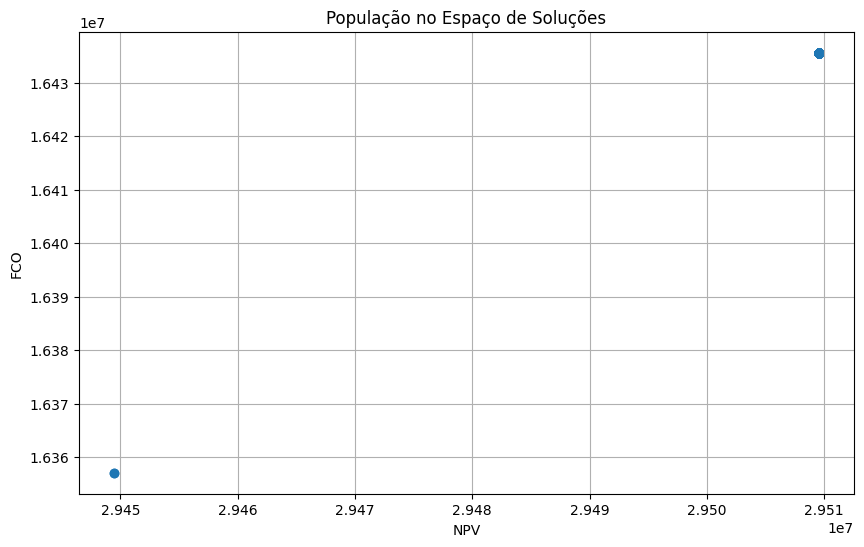

In [ ]:
# Plotar a fronteira de Pareto
# Pegar toda a população final e calcular os objetivos
F = np.zeros((res.pop.get("X").shape[0], 2))
for i, x in enumerate(res.pop.get("X")):
    F[i, 0] = problem.objective_rule(x)
    F[i, 1] = problem.alternate_objective_rule(x)

    print(f'Objetivo 1: {F[i, 0]}, Objetivo 2: {F[i, 1]}')

plt.figure(figsize=(10, 6))
plt.scatter(F[:, 1], F[:, 0])

plt.xlabel('NPV')
plt.ylabel('FCO')
plt.title('População no Espaço de Soluções')
plt.grid(True)
plt.show()

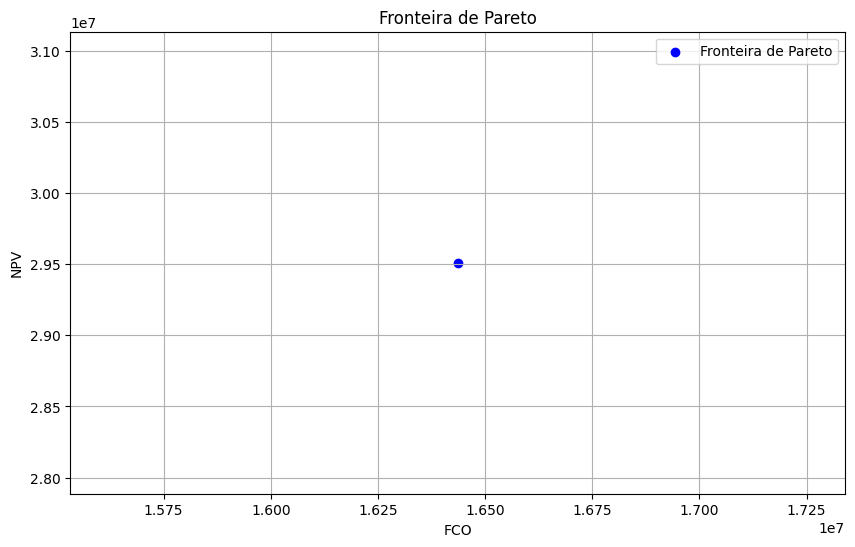

In [ ]:
F = res.F

plt.figure(figsize=(10, 6))
plt.scatter(-F[:, 0], -F[:, 1], color='blue', marker='o', label='Fronteira de Pareto')
plt.xlabel('FCO')
plt.ylabel('NPV')
plt.title('Fronteira de Pareto')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
F


array([[-16435630.49547857, -29509548.62515195]])